**Pedro Rivero**  
Technical Lead @ IBM Quantum  
pedro.rivero@ibm.com

- **Co-authors**: *Abdullah Ash Saki, Ritajit Majumdar, Haimeng Zhang*
- **Collaborators**: *Drew Vandeth, Mirko Amico, Nate Earnest-Noble, Borja Peropadre*

# Scale quantum computational workflows

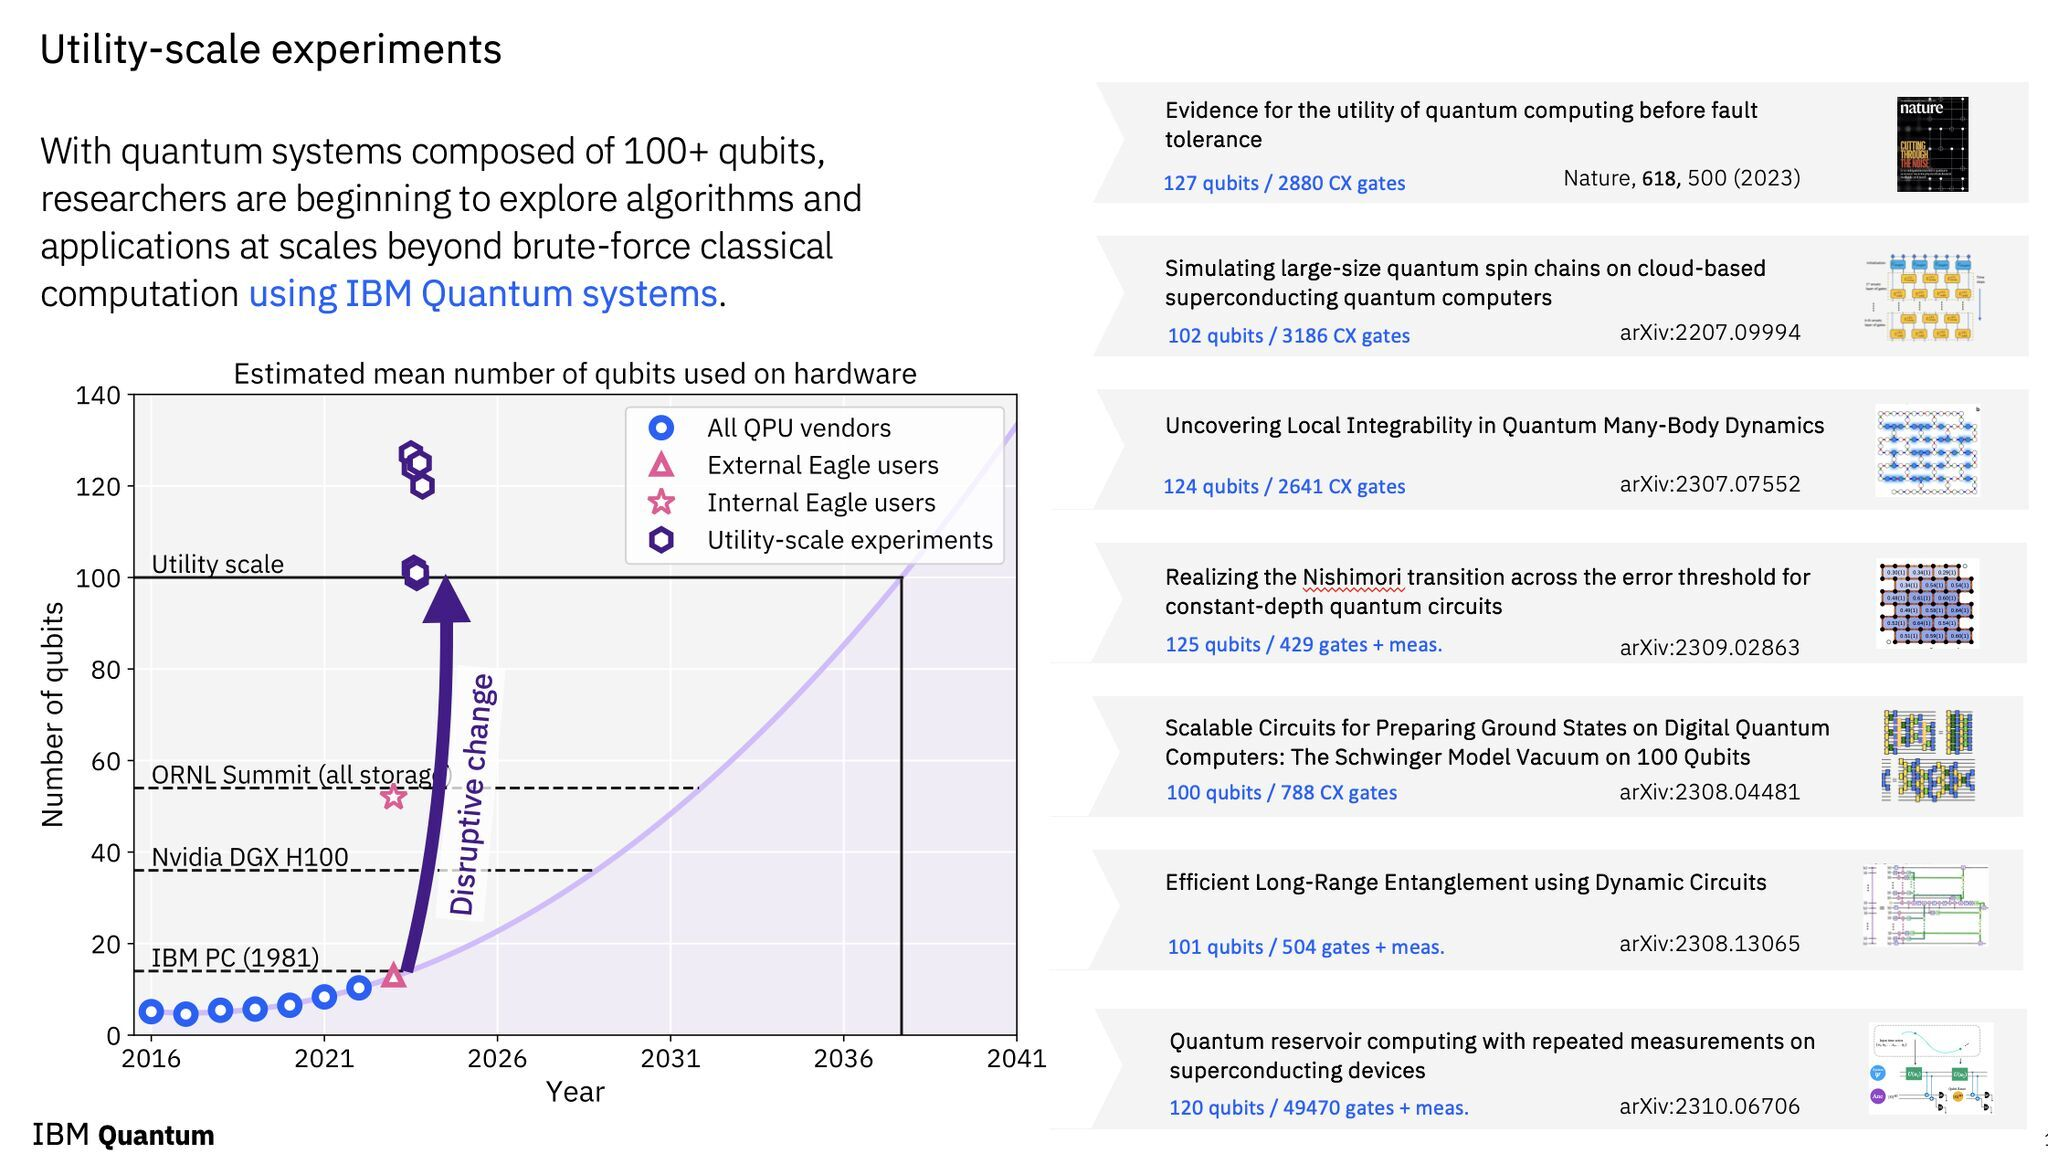

## Step 1: Generate quantum circuits

The circuits that we are going to explore in this notebook are meant to showcase how some relevant quantum pipelines can be scaled. To this end, we will begin studying different _hardware-native_ quantum circuits tied to the widely spread task of Hamiltonian simulation: 
- Quantum approximate optimization algorithm (QAOA)
- Transverse-field Ising model dynamics (TFIM)
- Many-body localization (MBL)

Due to the systems being described, these circuits will turn out equivalent in practice.

Then we will introduce a derivative form of the above circuits in order to address result validation: _mirror circuits_ following a compute-uncompute pattern (i.e. $U^\dagger U$). Finally, we will build our target virtual circuit to be executed at a given scale.

### Quantum approximate optimization algorithm (QAOA)

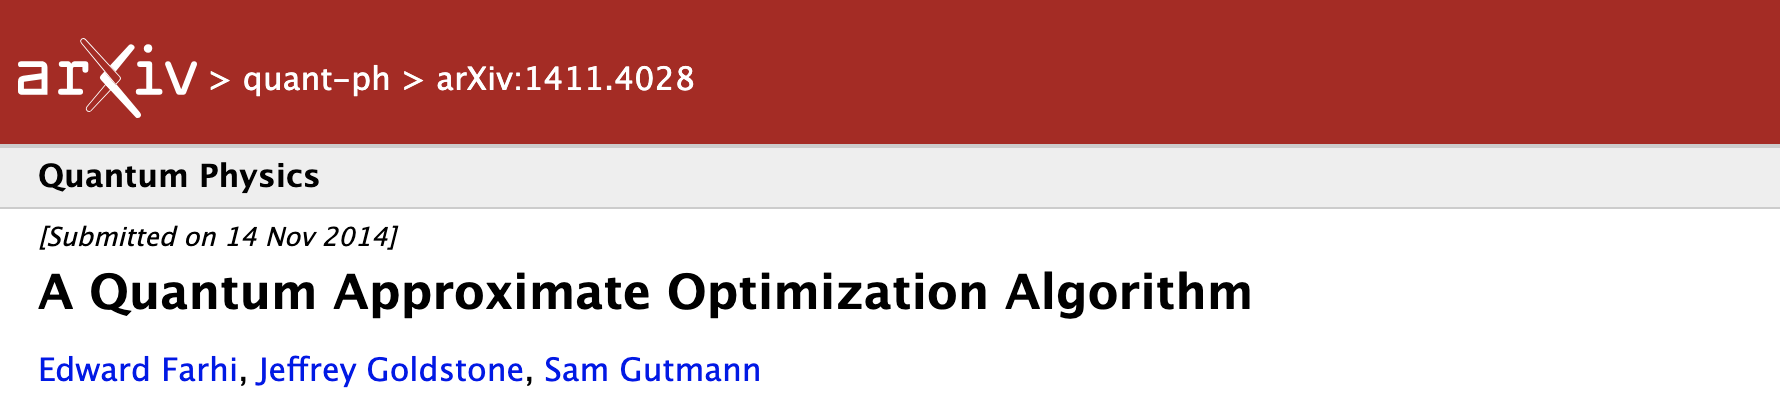

The first circuit candidate in our list is a [QAOA circuit](https://arxiv.org/abs/1411.4028) for a _MaxCut_ problem on a linear, acyclic, graph. 

This kind of graph ensures that the two-qubit density per layer will be almost as large as theoretically possible (see appendices), missing only one possible two-qubit gate every other layer which corresponds to connecting the first and last nodes of the graph. The reason why we refrain from doing so is so that the circuit remains _hardware-native_ regardless of the number of qubits (i.e. directly mappable onto the heavy-hex architecture of the latest IBM's quantum backends). Otherwise, auxiliry SWAP layers would need to be inserted, increasing the depth and reducing the overall two-qubit gate density without any gains towards more valuable results from a computational standpoint.

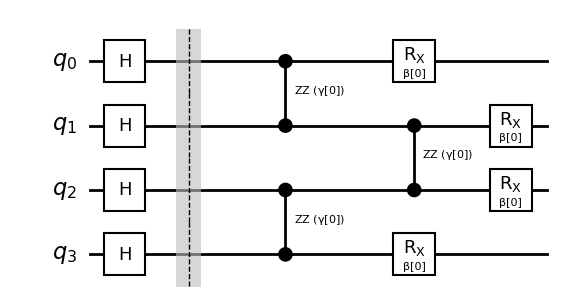

In [1]:
from quantum_enablement.circuits import QAOAPathCircuit

reference_circuit = QAOAPathCircuit(num_qubits=4, depth=2, barriers=True, measurements=False)

reference_circuit.draw("mpl", style="bw")

### Transverse-field Ising model dynamics (TFIM)

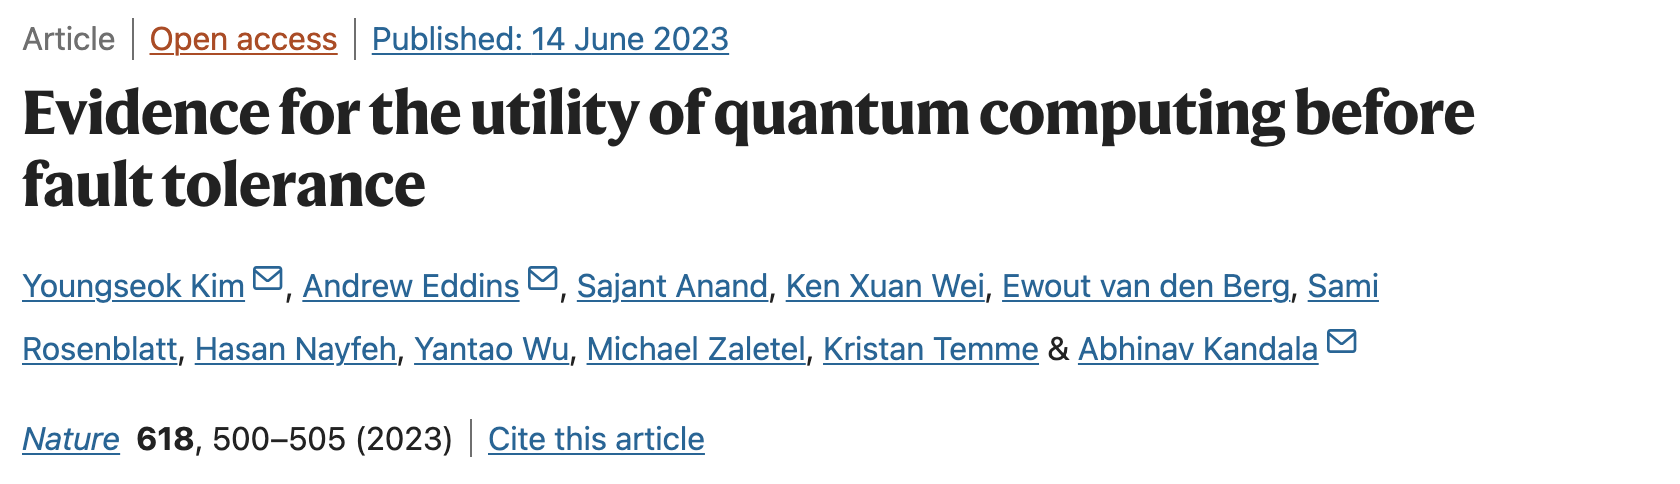

By construction, the previous QAOA circuit also represents the dynamics of a spin chain as pictured by the one-dimensional _transverse-field Ising model_ (TFIM) without periodic boundary conditions. The physics of this problem were studied in the [recent utility work](https://doi.org/10.1038/s41586-023-06096-3) by Kim et al.

### Many-body localization (MBL)

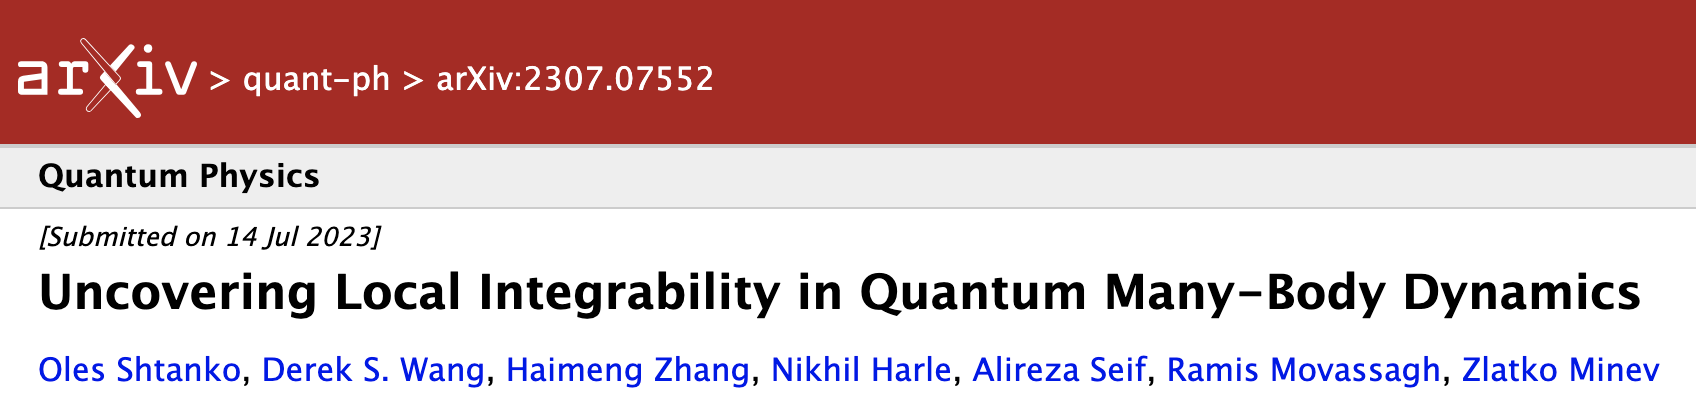

Another relevant circuit comes from [many-body localization (MBL)](https://www.youtube.com/watch?v=fWhmWbi-gaY), a mechanism by which disorder can stop thermalization. We will analyse a hardware-native one-dimensional realization as described in [recent work](https://arxiv.org/abs/2307.07552) by Shtanko et al.

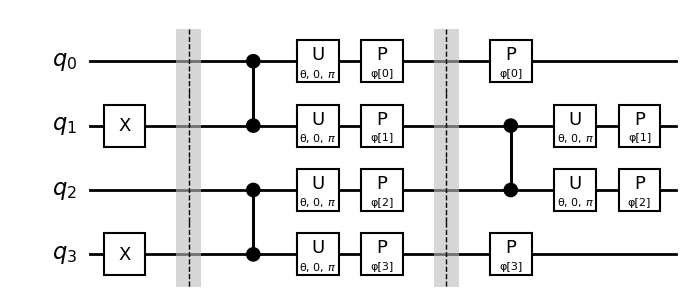

In [2]:
from quantum_enablement.circuits import MBLChainCircuit

reference_circuit = MBLChainCircuit(num_qubits=4, depth=2, barriers=True, measurements=False)

reference_circuit.draw("mpl", style="bw") 

Upon comparison, one realizes that this circuit looks very similar to the QAOA/TFIM one. Indeed, after transpilation the resulting physical circuits will be roughly indistinguishable from one another up to single qubit rotations which are to some extent random by construction. This justifies the study of only one of these circuits, since results will be naturally equivalent.

### Mirror circuits:  the compute-uncompute pattern

The problem with the previous circuits as they stand is that their final solution is in principle unknown, meaning that we do not have an understanding of whether the results that we get out of the quantum computer are good or not. This is a fundamental question that quantum computing faces as a field: how to _validate_ results beyond the reach of traditional methods.

As an active area of research, a number of tentative approaches exist; nonetheless, while they all have their merits, some would make our particular circuits too simple and not representative of the struggles faced by researchers (e.g. naive Cliffordization). For the purposes of this work, we are not going to try to find an overarching solution; instead, we will replace the previous circuits with derivatives that preserve the overall internal structure and richness, but whose final answer is trivially known and can be compared against. 

Concretely, we will use _mirror_ circuits made out of a first stage where the original circuit $\hat{U}$ is applied, and a second one where it is reversed $\hat{U}^\dagger$; following a _compute-uncompute_ pattern. The ideal outcome of such circuits will trivially be the input state $|0\rangle^{\otimes N}$, with expectation value one for any Pauli observable. These circuits will nonetheless pick up noise during the execution, which will distance their results from the ideal solution in ways that should be similar to those in the original circuit for equal number of qubits and two-qubit depth.

For execution, we also need to bind the circuit parameters to specific values and insert the desired measurements.

In [3]:
from qiskit import QuantumCircuit

def compute_uncompute(
    circuit: QuantumCircuit, *, barrier: bool = True, inplace: bool = False
) -> QuantumCircuit:
    """Build compute-uncompute version of input quantum circuit.

    Args:
        circuit: the original quantum circuit to build compute-uncompute version of.
        barrier: whether to insert a barrier between the compute and uncompute
            halves of the output circuit.
        inplace: if True, modify the input circuit. Otherwise make a copy.

    Returns:
        Compute-uncompute version of input quantum circuit with optional barrier.
    """
    if not isinstance(circuit, QuantumCircuit):
        raise TypeError(f"Invalid circuit type {type(circuit)}, expected <QuantumCircuit>.")
    inverse = circuit.inverse()
    if not inplace:
        circuit = circuit.copy()
    if barrier:
        circuit.barrier()
    circuit.compose(inverse, inplace=True)
    return circuit

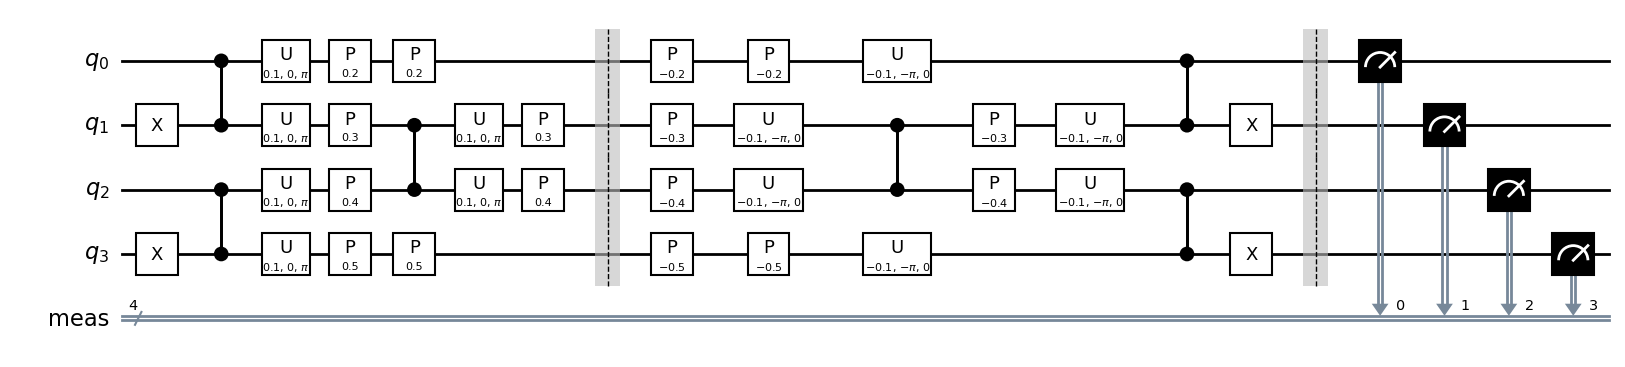

In [4]:
from quantum_enablement.circuits import MBLChainCircuit

reference_circuit = compute_uncompute(MBLChainCircuit(num_qubits=4, depth=2), barrier=True)
reference_circuit.assign_parameters([0.1, 0.2, 0.3, 0.4, 0.5], inplace=True)  # Note: dummy values
reference_circuit.measure_all()

reference_circuit.draw("mpl", style="bw")

> **NOTICE:**
> 
> - Qiskit requires a *barrier* to be placed between the compute and uncompute parts of the circuit to avoid simplification over transpilation later on. 
> - Also, the depth of the circuits is doubled by the *compute-uncompute* construct.

In [5]:
def adds_two_qubit_depth(instruction):
    """Returns True if the instruction adds two-qubit depth, False otherwise."""
    if instruction.operation.name == "barrier":
        return False
    return instruction.operation.num_qubits > 1

depth = reference_circuit.depth(adds_two_qubit_depth)  # Original depth = 2
print(f">> Compute-uncompute depth: {depth} (= 2 x 2)")

>> Compute-uncompute depth: 4 (= 2 x 2)


### Target virtual circuit

All things cosidered, we can now generate our target virtual circuit in the form of a compute-uncompute MBL circuit in 1D. Following the original paper, we will choose a strength of interaction parameter $\theta = 0.3 < 0.16 \pi$ (i.e. MBL regime), and disorder parameters $\vec\varphi$ randomly sampled from a uniform distribution on a qubit-by-qubit basis.

In [6]:
NUM_QUBITS = 12
DEPTH = 12

In [7]:
from numpy import pi
from numpy.random import default_rng

rng = default_rng(seed=0)

theta = 0.3  # Note: MBL regime for θ < 0.16π ≈ 0.5
phis = rng.uniform(-pi, pi, size=NUM_QUBITS).tolist()

print("PARAMETERS:")
print(f"  θ    := {theta}")
for qubit in range(NUM_QUBITS):
    print(f"  φ[{qubit}] := {phis[qubit]}")

PARAMETERS:
  θ    := 0.3
  φ[0] := 0.8605556614246863
  φ[1] := -1.4464727375963786
  φ[2] := -2.8841484100105235
  φ[3] := -3.03774645687452
  φ[4] := 1.9683349641197863
  φ[5] := 2.5934197786078093
  φ[6] := 0.6700123395200417
  φ[7] := 1.441969420022903
  φ[8] := 0.27410390540137985
  φ[9] := 2.7336406607023154
  φ[10] := 1.9845664104768632
  φ[11] := -3.1243861495570098


In [8]:
from quantum_enablement.circuits import compute_uncompute, MBLChainCircuit

virtual_circuit = compute_uncompute(MBLChainCircuit(NUM_QUBITS, DEPTH // 2), barrier=True)
virtual_circuit.assign_parameters([theta, *phis], inplace=True)
virtual_circuit.measure_all()

assert virtual_circuit.num_parameters == 0, "Circuit still contains parameters."
assert virtual_circuit.depth(adds_two_qubit_depth) == DEPTH, "Incorrect circuit depth."

## Step 2: Optimize problem for quantum execution

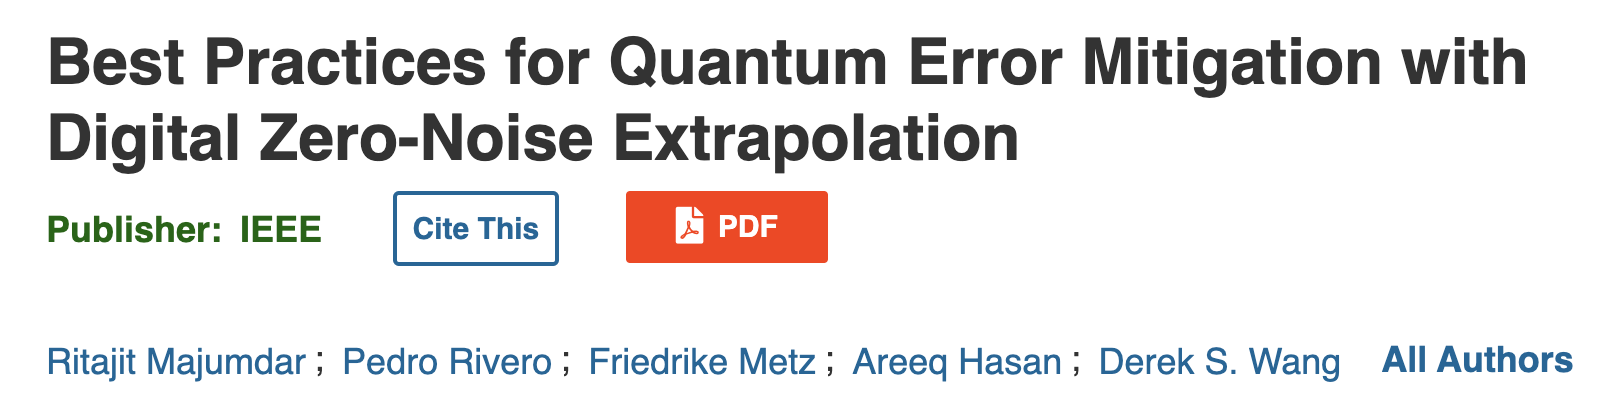

Much of the work that we wil be discussing here comes from original published research on [best practices for quantum error mitigation](https://arxiv.org/abs/2307.05203). Particualrly, we will focus on practical implementations of different error mitigation techniques. Please refer to the original references for comprehensive explanations, as we will only explain them briefly here.
- Transpilation
- Pauli Twirling (PT)
- Zero-noise extrapolation (ZNE)
- Dynamical decoupling (DD)
- Matrix-free measurement mitigation (M3)

### Transpilation

Transpilation is the process of rewriting a given input circuit to match the topology and native gate set of a specific quantum device, and/or to optimize the circuit for execution on present day noisy quantum systems. In other words, it allows to convert an input _virtual circuit_ into an output _physical circuit_ that can be executed directly on particular hardware. For details please visit [Qiskit's documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler).

The first thing that we need is selecting the physical hardware to run things on:

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

SERVICE = QiskitRuntimeService()
BACKEND = SERVICE.backend("ibm_pinguino1")

We will then use Qiskit's `preset_passmanagers` to carry out transpilation easily. We will set `optimization_level=3` in order to optimize the physical circuits as much as possible, and `seed_transpiler=0` for reproducibility.

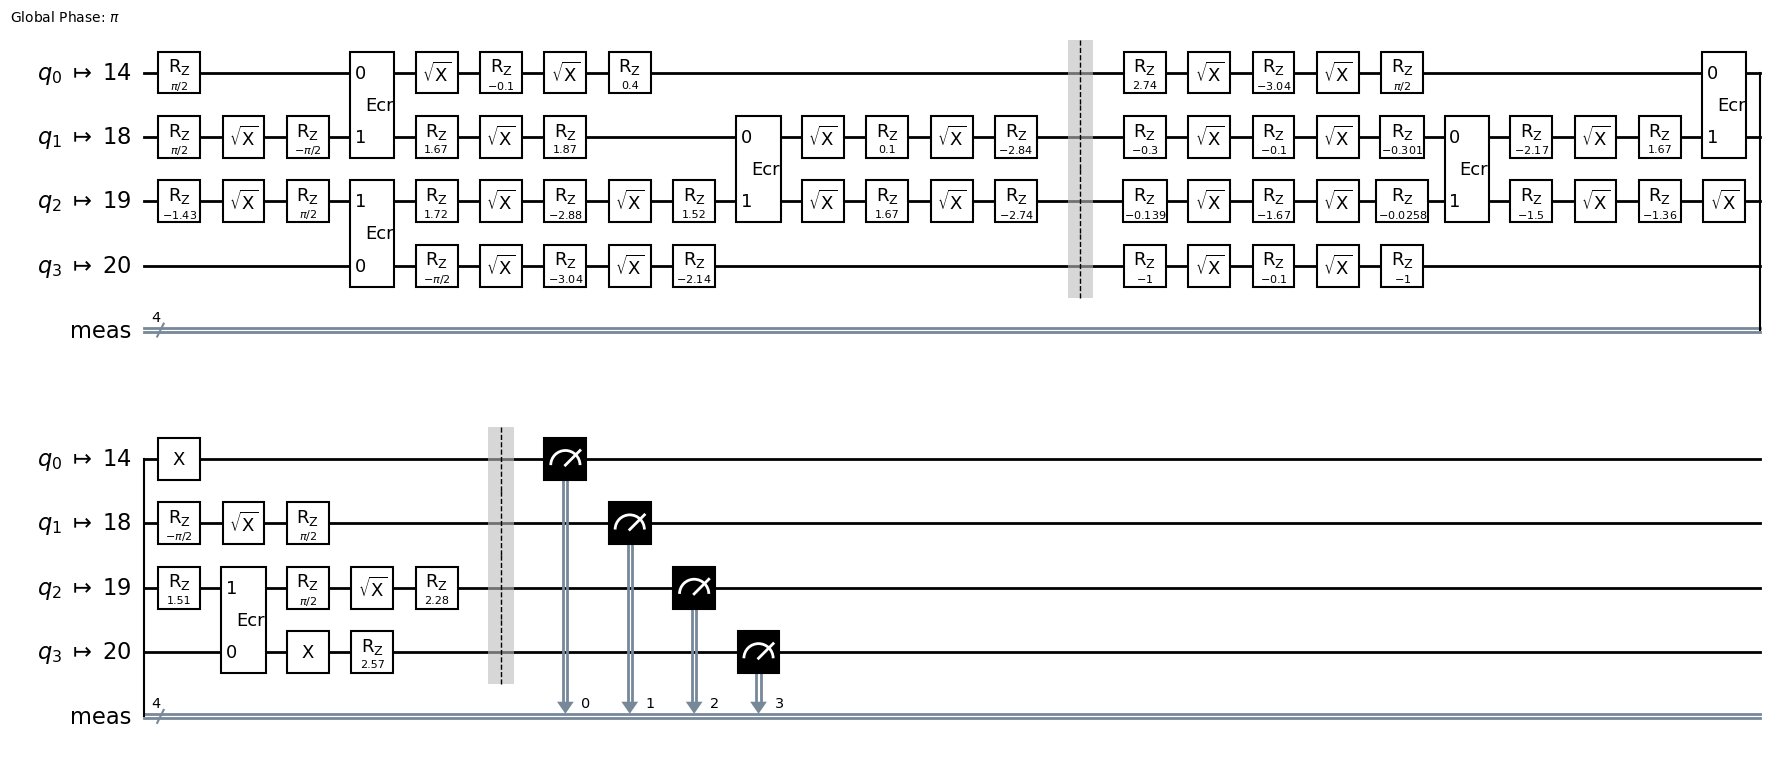

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

TRANSPILATION = generate_preset_pass_manager(backend=BACKEND, optimization_level=3, seed_transpiler=0)

reference_circuit = TRANSPILATION.run(reference_circuit)
reference_circuit.draw("mpl", idle_wires=False, style="bw")

> **NOTICE:**
> 
> Latest IBM quantum hardware uses the (directed) _echoed cross-resonance_ (ECR) gate as its native two-qubit gate unlike previous devices which used CNOT.
> These two gates are equivalent to one another up to single qubit operations.
  

In [11]:
physical_circuit = TRANSPILATION.run(virtual_circuit)

### Pauli twirling (PT)

[_Twirling_](https://www.zlatko-minev.com/blog/twirling) or _randomized compiling_ is a well known and widely used technique for converting arbitrary noise channels into other forms of noise. 

Pauli twirling is a special kind of twirling based on the Pauli set, and it has the effect of transforming any quantum channel into a Pauli channel. In and on itself, this has benefits when dealing, for instance, with coherent noise; since that tends to accumulate quadratically whereas Pauli noise accumulates linearly. Furthermore, Pauli channels offer secondhand benefits compared to other types of noise. For instance, thanks to Pauli noise being unital, it helps in the the extrapolation stage of ZNE by making quantum states tend towards the maximally mixed state somewhat monotonically. Since most of the errors in current quantum hardware come from two-qubit gates, this technique is often applied exclusively to (native) two-qubit gates.

In practice, Pauli Twirling is implemented by randomly substituting (noisy) gates for equivalent ones (i.e. representing the same unitary) made out of the original sandwhiched between Paulis. This is done over several randomizations leading to an ensemble of circuits to execute instead of only the original one. One can check through basic matrix algebra that there are a total of sixteen Pauli twirls both for CNOT and ECR gates —something to be expected sice both gates are Clifford. For instance:

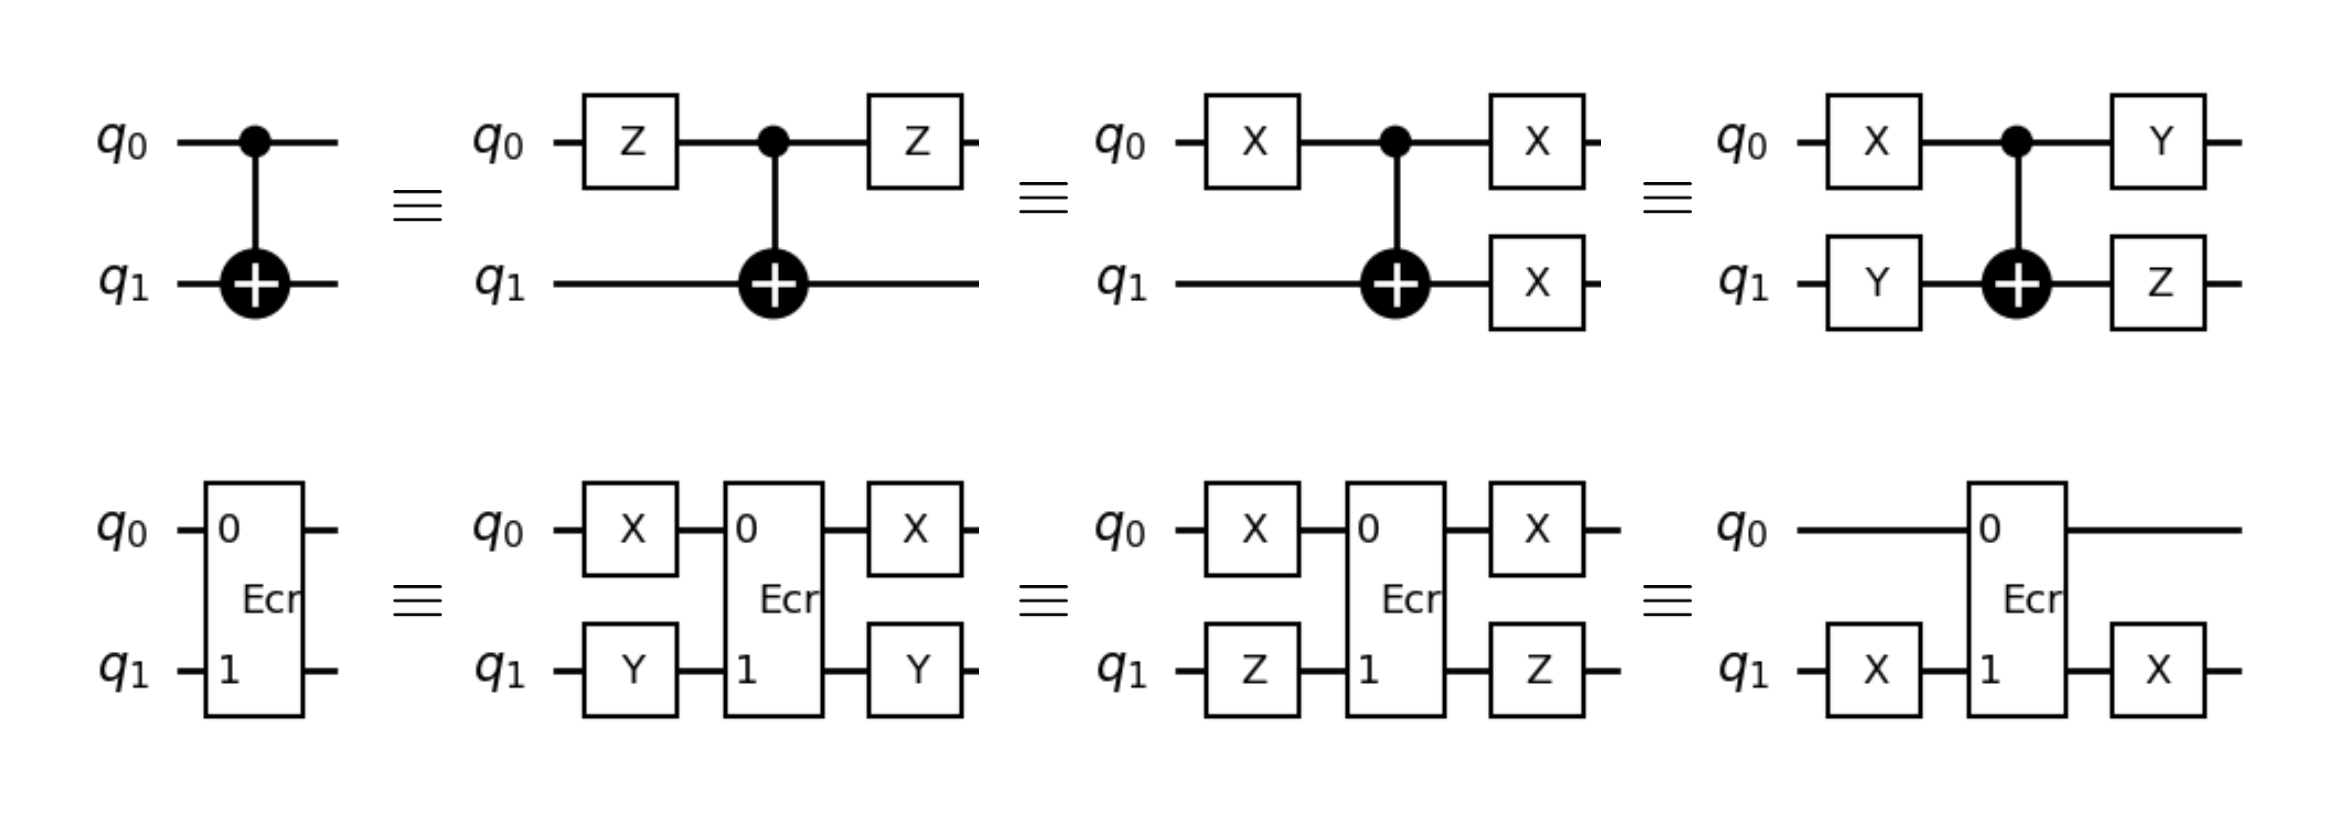

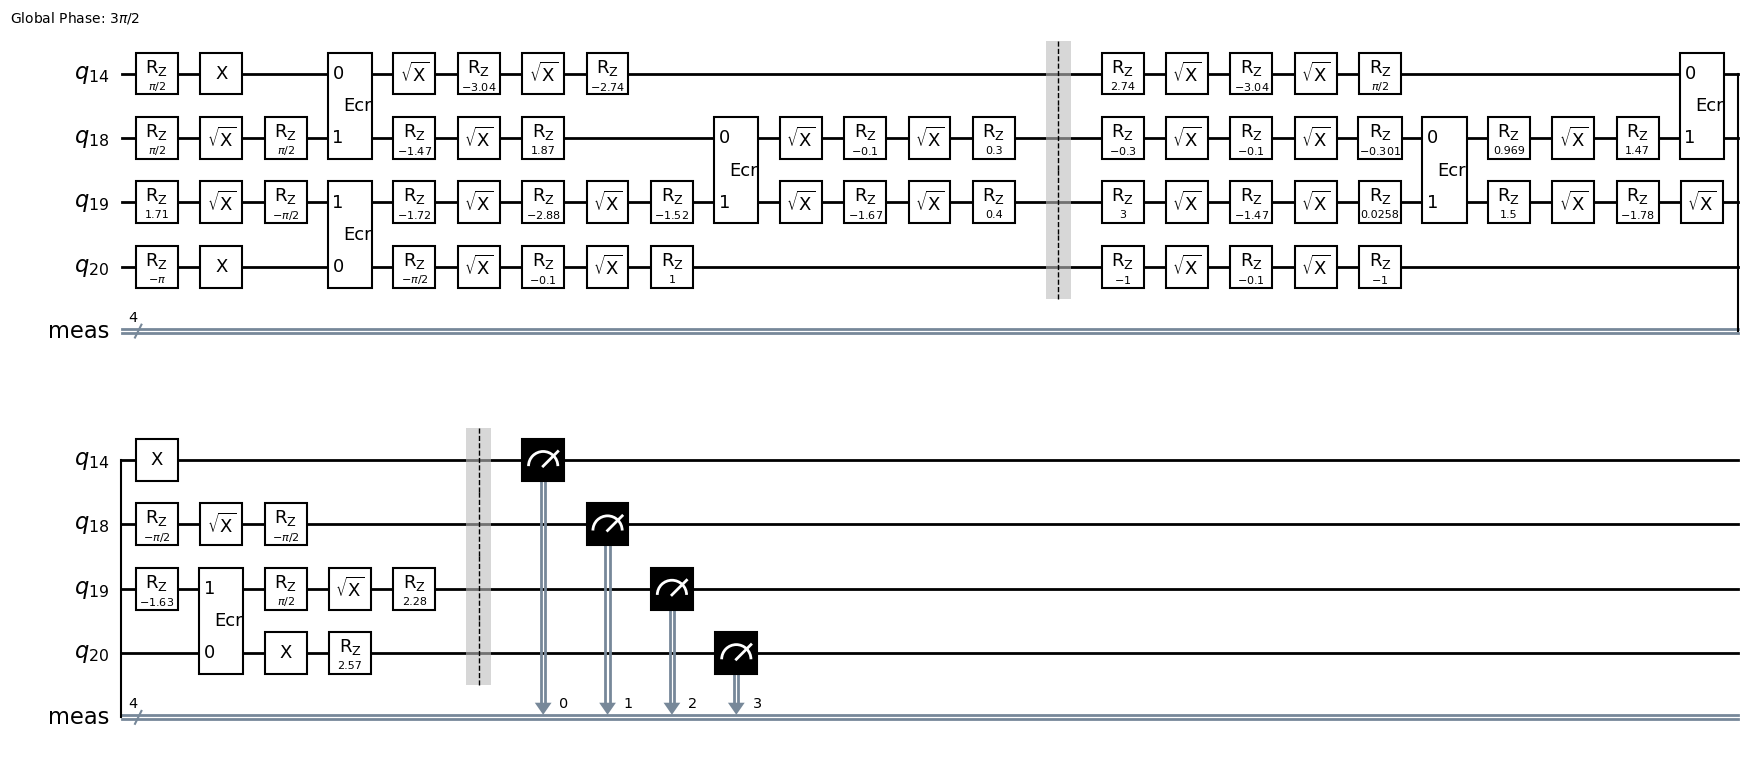

In [12]:
from quantum_enablement.mitigation import TwoQubitPauliTwirlPass
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Decompose, Optimize1qGatesDecomposition

PAULI_TWIRLING = PassManager([
    TwoQubitPauliTwirlPass(seed=0),
    Decompose('pauli'), 
    Optimize1qGatesDecomposition(BACKEND.operation_names),
])

example_circuit = PAULI_TWIRLING.run(reference_circuit)
example_circuit.draw("mpl", idle_wires=False, style="bw")

### Zero-noise extrapolation (ZNE)

Zero-noise extrapolation (ZNE) is an error mitigation technique that can be applied when computing expectation values from observables. This approach tends to reduce errors in expectation values, but is not guaranteed to produce an unbiased result. It is divided into two stages:
1. _Noise amplification_: the original quantum circuit is executed at different noise levels.
2. _Extrapolation_: from the noisy (expectation value) results the ideal result in the zero-noise limit is inferred.

While there are many ways to perform noise amplification, some of them can be tedious to implement or requiere low level access to hardware. Here we will use the _partial-folding_ strategy described in [best practices paper](https://arxiv.org/abs/2307.05203), which consist on replacing (two-qubit) gates $U$ with equivalent sequences of the form $U(U^\dagger U)^f$ to apply noise factors $\lambda(f) = 2f + 1$. This is particularly effective when the gates are _self-inverse_ (i.e. hermitian $U^\dagger = U$) as is the case with the CNOT and ECR gates.

Performing these substitions over a subset of gates allows to reach non-odd-integer noise factors. Furthermore, repeating this operation over several randomized subsets (i.e. resulting in an ensemble of circuits) has proven effective in attaining more precise results. We can use the [`prototype-zne` software package](https://pypi.org/project/prototype-zne/) to carry out this task easily.

We will choose noise factors based on two-qubit depth from a liner map starting at `(1.0, 3.0, 5.0)` for depth four, to `(1.0, 1.2, 1.5)` for depth sixty four. This will ensure that enough gates exist to perform the necessary fine-grained noise amplification via partial folding, as well as that the amplified circuits remain shallow enough.

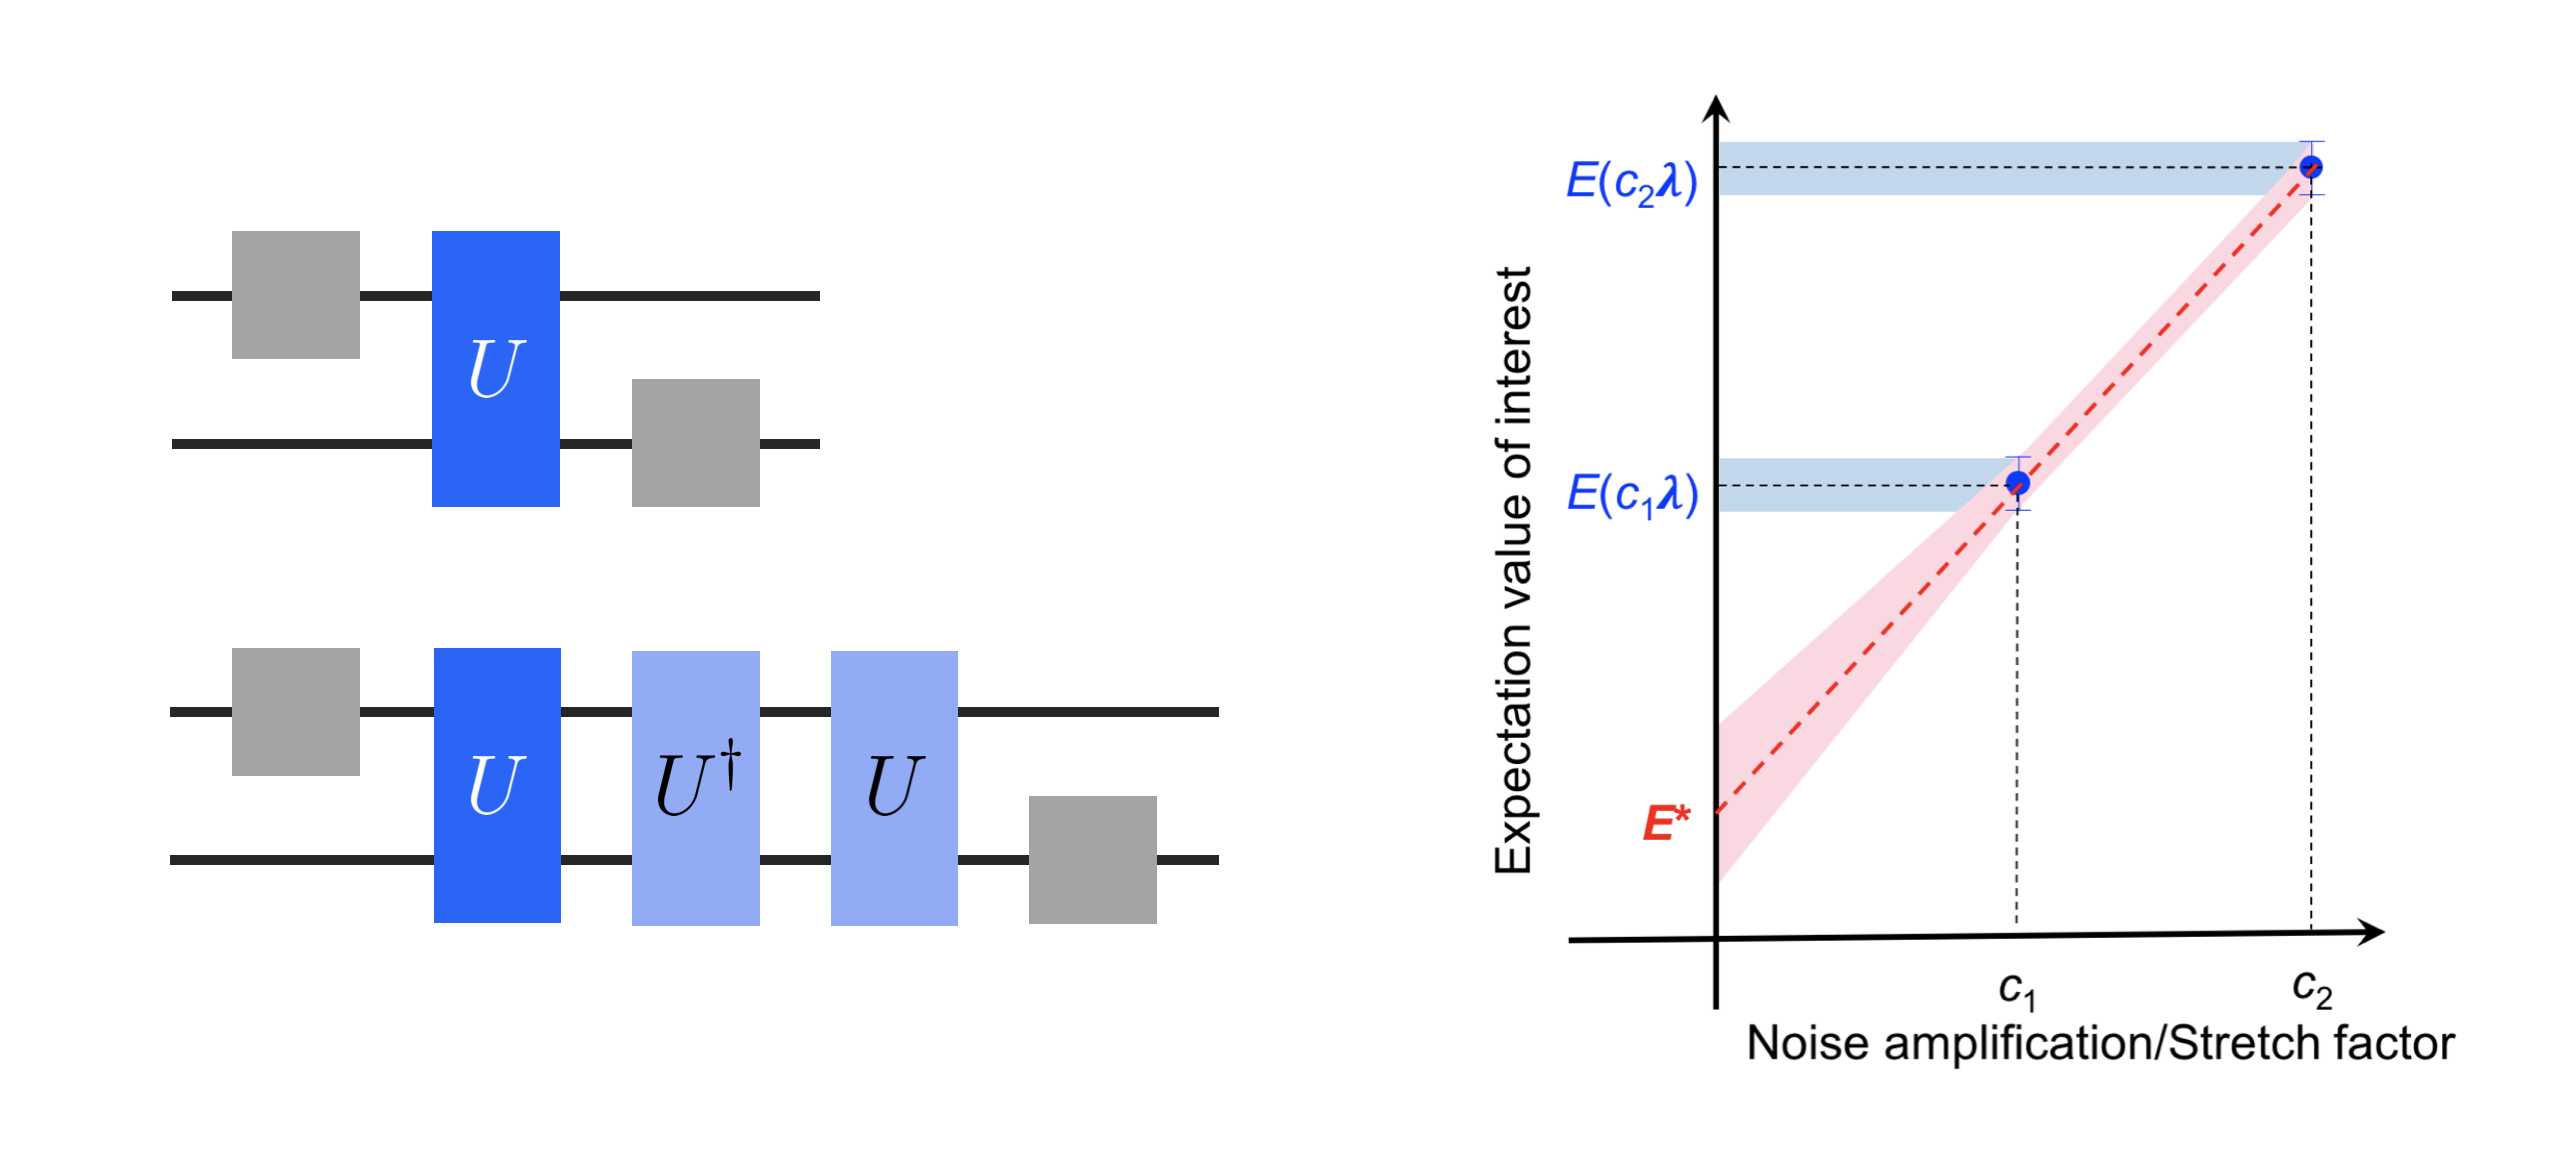

In [13]:
from numpy import interp
from zne.noise_amplification import TwoQubitAmplifier

def produce_noise_factors(depth):
    """Noise factors as a function of depth."""
    COARSE = (1.0, 3.0, 5.0)
    FINE = (1.0, 1.2, 1.5)
    DEPTHS = (4, 64)
    return tuple(
        interp(depth, DEPTHS, [coarse, fine])
        for coarse, fine in zip(COARSE, FINE)
    )

NOISE_FACTORS = produce_noise_factors(DEPTH)
NOISE_AMPLIFIER = TwoQubitAmplifier(sub_folding_option='random', barriers=False, random_seed=0)

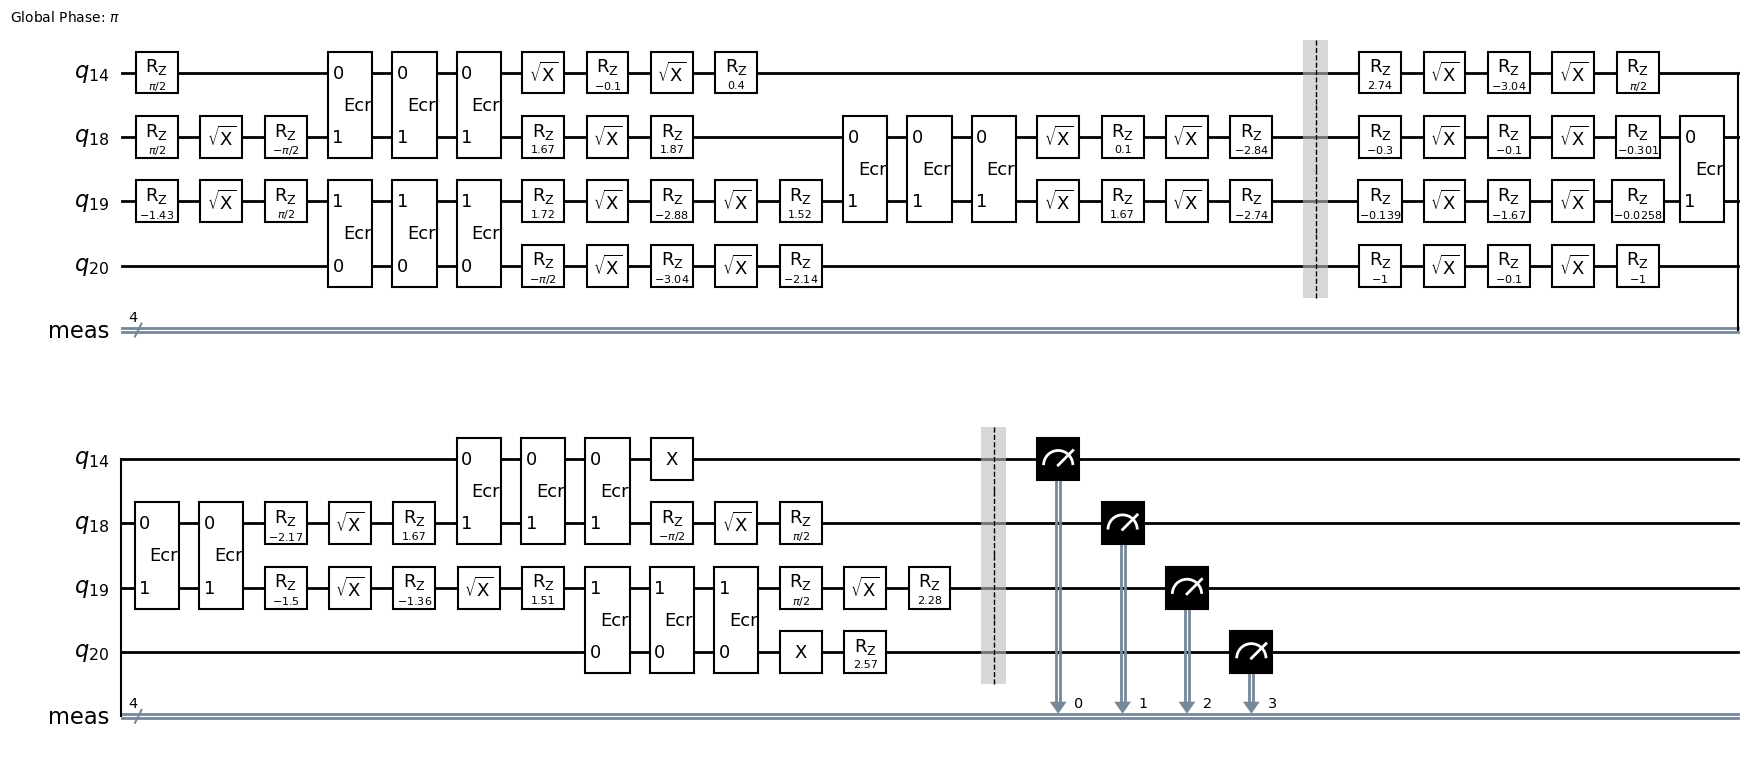

In [14]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers

NOISE_AMPLIFICATION = NOISE_AMPLIFIER.build_pass_manager(noise_factor=3)

example_circuit = NOISE_AMPLIFICATION.run(reference_circuit)
example_circuit.draw("mpl", idle_wires=False, style="bw")

### Dynamical decoupling (DD)

Quantum circuits are executed on IBM hardware as sequences of microwave pulses that need to be scheduled and run at precise time intervals. Let's take a look at this:

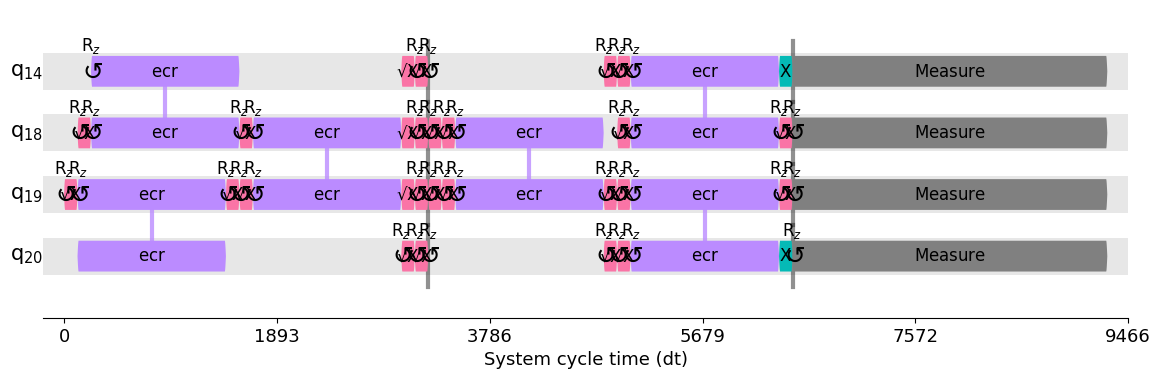

In [15]:
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDelay
from qiskit.visualization import timeline_drawer

SCHEDULING = PassManager([
    ALAPScheduleAnalysis(BACKEND.target.durations()), 
    PadDelay()
])

example_circuit = SCHEDULING.run(reference_circuit)
timeline_drawer(example_circuit, show_idle=False)

Unfortunately, qubits on the hardware can couple to each other and the induced _crosstalk_ effect can lead to coherent errors on idling qubits. Thefore having qubits waiting until the next pulse can be applied may result in larger error rates. To prevent this from happening, we can insert sequences of operations during those idle times as long as they amount to an identity. Different sequences will have different effects, and which sequence is better for each particular case remains an active area of research. This procedure is known in the literature as [_dynamical decoupling_ (DD)](https://arxiv.org/abs/2207.03670).

Furthermore, idle times will become larger after performing gate folding to increase the circuit's noise for ZNE. Therefore, for different noise factors it may be reasonable to use different DD sequences. In the interest of time, we leave this as an exercise for the reader, and limit ourselves to applying simple $XX$ sequences.

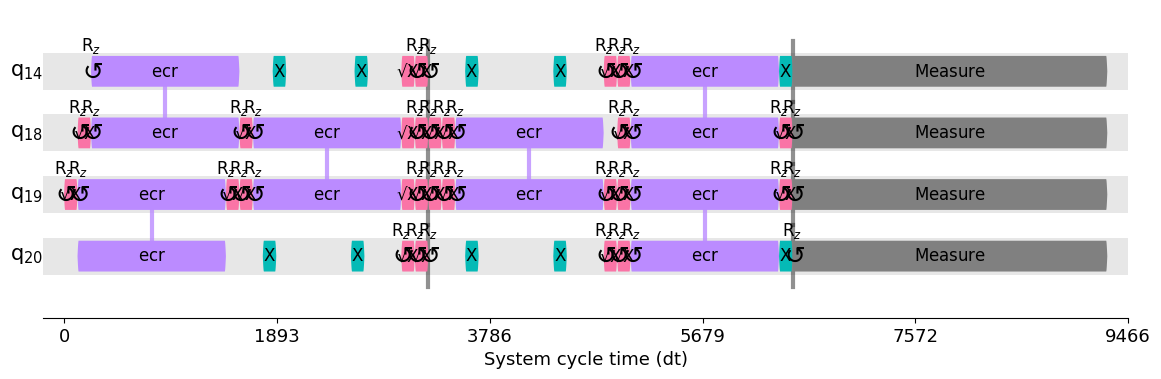

In [16]:
from qiskit.circuit.library import XGate
from qiskit.transpiler.passes import PadDynamicalDecoupling

DD_SEQUENCE = [XGate(), XGate()]
TARGET = BACKEND.target
PULSE_ALIGNEMENT = TARGET.timing_constraints().pulse_alignment

DYNAMICAL_DECOUPLING = PassManager([
    ALAPScheduleAnalysis(target=TARGET), 
    PadDynamicalDecoupling(dd_sequence=DD_SEQUENCE,target=TARGET,pulse_alignment=PULSE_ALIGNEMENT)
])

example_circuit = DYNAMICAL_DECOUPLING.run(reference_circuit)
timeline_drawer(example_circuit, show_idle=False)

### Matrix-free measurement mitigation (M3)

[Matrix-free measurement mitigation (M3)](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040326) is an efficient method for mitigating measurement errors on quantum computing platforms that accomodates for both uncorrelated and correlated errors. In order for it to be applied, it needs to be calibrated through the single-qubit _measurement confusion matrices_. To do so, we prepare two calibration circuits:
- Calibrate readout zero on all qubits.
- Calibrate readout one on all qubits.

Marginalizing the results to individual qubits will allow us to build the required matrices $P_{i,j}^{(q)}$ representing the probability of the $q$-th qubit being in state $j \in \{0, 1\}$ and measured in state $i \in \{0, 1\}$:
$$
\vec{p}_\text{noisy} =
\begin{bmatrix}
P_{0,0}^{(q)} & P_{0,1}^{(q)} \\
P_{1,0}^{(q)} & P_{1,1}^{(q)}
\end{bmatrix}
\vec{p}_\text{ideal}
$$

In [17]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile

READOUT_QUBITS = physical_circuit.layout.final_index_layout(filter_ancillas=True)

calibration_0 = QuantumCircuit(NUM_QUBITS)
calibration_0.measure_all()
calibration_0 = transpile(calibration_0, BACKEND, initial_layout=READOUT_QUBITS)

calibration_1 = QuantumCircuit(NUM_QUBITS)
calibration_1.x(range(NUM_QUBITS))
calibration_1.measure_all()
calibration_1 = transpile(calibration_1, BACKEND, initial_layout=READOUT_QUBITS)

calibration_circuits = [calibration_0, calibration_1]

### Stacking error mitigation strategies

We can now stack all the above error mitigation techniques by building an error mitigation _pass-manager_ that performs all the appropriate transformations in the right order.

In [18]:
from qiskit.transpiler import StagedPassManager

def build_error_mitigation_pass_manager(noise_factor):
    """Generate error mitigation pass manager."""
    stages = {
        'pauli_twirling': PAULI_TWIRLING,
        'noise_amplification': NOISE_AMPLIFIER.build_pass_manager(noise_factor),
        'dynamical_decoupling': DYNAMICAL_DECOUPLING,
    }
    return StagedPassManager(stages, **stages)

> **WARNING:**
> 
>    There is an open research question as to whether Twirling or noise amplification (i.e. gate folding) should occur first. In the present work we apply twirling first in order to reduce the overall (single-qubit) depth of the resulting amplified circuits at the expense of possibly some unmitigated coherent noise.

With this pass-manager at hand, we can now generate random ensembles of equivalent quantum circuits that will serve as our vehicle for performing error mitigation.

In [19]:
def generate_error_mitigation_circuits(
    circuit, num_randomizations: int = 1, noise_factor: float = 1.0
):
    """Generate error mitigation circuits."""
    pass_manager = build_error_mitigation_pass_manager(noise_factor)
    for _ in range(num_randomizations):
        yield pass_manager.run(circuit)

## Step 3: Execute using Qiskit Primitives

In [20]:
from math import ceil

SHOTS = 100_000
NUM_RANDOMIZATIONS = 10

SHOTS_PER_RANDOMIZATION = ceil(SHOTS / NUM_RANDOMIZATIONS)

### Run jobs

We can now use _Qiskit IBM Runtime_ to execute our payload on quantum hardware and retrieve results. 

Since we are manually implementing our custom error mitigation strategies, we need to configure runtime to drop its own; alternatively, whenever possible from a theory standpoint, one could retain a selection of Runtime's error mitigation features and stack new custom ones on top.

Using Runtime _sessions_ we can submit both principal and calibration jobs to be run jointly without queing delays. This is critical in order to guarantee that the resulting callibration is representative of the noise present during the main workload execution.

In [21]:
from qiskit_ibm_runtime import Session, SamplerV2

circuits = {
    nf: generate_error_mitigation_circuits(physical_circuit, NUM_RANDOMIZATIONS, nf)
    for nf in NOISE_FACTORS
}
circuits = [circuit for batch in circuits.values() for circuit in batch]

with Session(service=SERVICE, backend=BACKEND) as session:
    sampler = SamplerV2(session=session)
    jobs = [sampler.run(circuits, shots=SHOTS_PER_RANDOMIZATION)]
    calibration_jobs = [sampler.run(calibration_circuits, shots=SHOTS)]

Once the jobs are submitted, it is advised to get their IDs in order to track down the results:

In [22]:
print("JOB IDs:")
for job in jobs:
    print(f"  >> {job.job_id()}")

print("\nCALIBRATION JOB IDs:")
for job in calibration_jobs:
    print(f"  >> {job.job_id()}")

JOB IDs:
  >> cqrcd5424gr0008qnb20

CALIBRATION JOB IDs:
  >> cqrcd5c2gs5g008swmr0


On top of that, it is generally a good idea to generate a _unique reference_ to identify the execution. A (UTC) _timestamp_ is valuable for this among other things, and can easily be created automatically with the help of Python's builtin functions:

In [23]:
from datetime import datetime, UTC

TIMESTAMP = f'{datetime.now(UTC).isoformat()}'
print(f">> Timestamp: {TIMESTAMP}")

>> Timestamp: 2024-03-12T21:18:13.498254+00:00


### Save experiment metadata

At this point we should be waiting for results to be returned from the servers connected to the quantum hardware; and we may possibly face some of the following:

- Long queues delaying the execution of our jobs.
- Large payloads taking a long time to run.
- Connection issues due to unstable networks or outages.

Therefore, it may be a good time to create a _checkpoint_. This will allow us to pick the work back up easily in the future. It will also facilitate later resubmission of failed jobs while keeping the results of those that succeeded —making our hardware usage more efficient.

Generally speaking, to create a checkpoint, you just need to store all the relevant information that allows you to recreate the current state of your work _exactly_ —or at least the parts of it that will be needed in later stages. We recommend storing additional helper metadata as well.

In [24]:
excution_data = {
    'timestamp': TIMESTAMP,
    'backend': BACKEND.name,
    'jobs': [job.job_id() for job in jobs],
    'calibration_jobs': [job.job_id() for job in calibration_jobs],
    'shots': SHOTS,
}

circuit_data = {
    'circuit': f'CU-MBL<{NUM_QUBITS}, {DEPTH}>({theta=:.5f}, {phis=})',
    'num_qubits': NUM_QUBITS,
    'depth': DEPTH,
    'initial_layout': physical_circuit.layout.initial_index_layout(filter_ancillas=True),
    'final_layout': physical_circuit.layout.final_index_layout(filter_ancillas=True),
}

mitigation_data ={
    'mitigation_techniques': ['m3', 'pt', 'zne', 'dd'],
    'num_randomizations': NUM_RANDOMIZATIONS,
    'noise_factors': NOISE_FACTORS,
    'noise_amplifier': NOISE_AMPLIFIER.name,
    'dd_sequence': [gate.name for gate in DD_SEQUENCE],
}

METADATA = {**excution_data, **circuit_data, **mitigation_data}

We can easily dump all this information into a `.json` file:

In [25]:
from json import dump

FILENAME = f'{NUM_QUBITS}x{DEPTH}_{TIMESTAMP}.json'.replace(':', '.')  # Windows disallows ':' in filenames
with open(FILENAME, 'w') as file:
    checkpoint = {'metadata': METADATA}
    dump(checkpoint, file, indent=4)

print(f">> Checkpoint saved in: `{FILENAME}`")

>> Checkpoint saved in: `12x12_2024-03-12T21.18.13.498254+00.00.json`


### Load experiment metadata

After some wait our [jobs have completed](https://quantum.ibm.com/jobs) and results are now ready! 

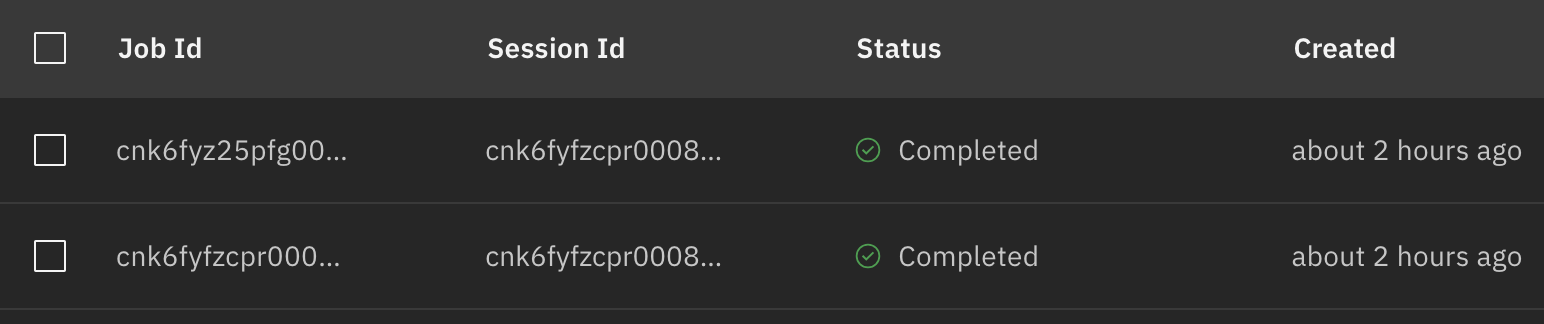

Let's reload our environment from the checkpoint in order to retrieve them:

In [1]:
from json import load

FILENAME = "12x12_2024-03-12T21.18.13.498254+00.00.json"
with open(FILENAME, 'r') as file:
    checkpoint = load(file)

In [2]:
METADATA = checkpoint.get('metadata')

NUM_QUBITS = METADATA.get('num_qubits')
DEPTH = METADATA.get('depth')
NUM_RANDOMIZATIONS = METADATA.get('num_randomizations')
NOISE_FACTORS = METADATA.get('noise_factors')

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

SERVICE = QiskitRuntimeService()
jobs = [SERVICE.job(id) for id in METADATA.get('jobs')]
calibration_jobs = [SERVICE.job(id) for id in METADATA.get('calibration_jobs')]

### Retrieve and unpack results

We can now fetch the raw results:

In [4]:
results = [job.result() for job in jobs]
calibration_results = [job.result() for job in calibration_jobs]

And unpack them into a sensible structure for easy manipulaiton:

In [5]:
def unpack_results(counts_iterable):
    counts_iterator = iter(counts_iterable)
    for noise_factor in NOISE_FACTORS:
        for _ in range(NUM_RANDOMIZATIONS):
            yield noise_factor, next(counts_iterator)

In [6]:
from collections import defaultdict

counts_list = [
    pub_result.data.meas.get_counts() 
    for primitive_result in results 
    for pub_result in primitive_result
]
assert len(counts_list) == len(NOISE_FACTORS) * NUM_RANDOMIZATIONS

results_dict = defaultdict(list)
for noise_factor, counts in unpack_results(counts_list):
    results_dict[noise_factor].append(counts)

for noise_factor, counts_list in results_dict.items():
    print(f">> Noise-factor ({noise_factor:.2f}): {len(counts_list)} counts entries")

>> Noise-factor (1.00): 10 counts entries
>> Noise-factor (2.76): 10 counts entries
>> Noise-factor (4.53): 10 counts entries


In [7]:
calibration_counts_list = [
    pub_result.data.meas.get_counts() 
    for primitive_result in calibration_results 
    for pub_result in primitive_result
]
assert len(calibration_counts_list) == 2

calibration_dict = {
    ideal_readout: calibration_counts_list[ideal_readout]
    for ideal_readout in (0, 1)
}

### Save experiment data

We may want to save these results locally for ease of access, to share them, or to work offline. A new checkpoint with additional information can be created for this, either overriding the previous file or not:

In [8]:
from json import dump

FILENAME = FILENAME  # Update previous file
with open(FILENAME, 'w') as file:
    checkpoint = {
        'metadata': METADATA, 
        'calibrations': calibration_dict, 
        'results': results_dict
    }
    dump(checkpoint, file, indent=4)

print(f">> Checkpoint saved in: `{FILENAME}`")

>> Checkpoint saved in: `12x12_2024-03-12T21.18.13.498254+00.00.json`


## Step 4: Post-process

### Load experiment data

Whenever we want to work on the previously produced results, we can conveniently load them from our checkpoint:

In [1]:
from json import load

FILENAME = "12x12_2024-03-12T21.18.13.498254+00.00.json"
with open(FILENAME, 'r') as file:
    checkpoint = load(file)

In [2]:
METADATA = checkpoint.get('metadata')

NUM_QUBITS = METADATA.get('num_qubits')
DEPTH = METADATA.get('depth')
NUM_RANDOMIZATIONS = METADATA.get('num_randomizations')
NOISE_FACTORS = METADATA.get('noise_factors')

In [3]:
calibration_dict = {
    int(ideal_readout): counts 
    for ideal_readout, counts in checkpoint.get('calibrations').items()
}
results_dict = {
    float(noise_factor): counts_list
    for noise_factor, counts_list in checkpoint.get('results').items()
}

### Calibrate M3

From the calibration results, we can now build our calibration for our measurement error mitigation protocol (M3). This is done by computing all relevant single-qubit _measurement confusion matrices_ $P_{i,j}^{(q)}$ from the callibration data, and feeding them to the [`mthree` software package](https://github.com/Qiskit-Extensions/mthree/tree/main) that will do the mitigation for us:

In [4]:
from qiskit.result import marginal_distribution
from numpy import array

def generate_calibration_matrices(calibration_dict, readout_qubits):
    """Generate calibration matrices from calibration results."""
    shots_0 = sum(calibration_dict.get(0).values())
    shots_1 = sum(calibration_dict.get(1).values())
    assert shots_0 == shots_1
    for n, qubit in enumerate(readout_qubits):
        prepared_0 = marginal_distribution(calibration_dict.get(0), [n])
        prepared_1 = marginal_distribution(calibration_dict.get(1), [n])
        matrix = [
            [prepared_0.get('0', 0), prepared_1.get('0', 0)], 
            [prepared_0.get('1', 0), prepared_1.get('1', 0)],
        ]
        yield qubit, array(matrix) / shots_0

In [5]:
from mthree import M3Mitigation

M3 = M3Mitigation()
m3_calibrations = dict(generate_calibration_matrices(calibration_dict, range(NUM_QUBITS)))
M3.cals_from_matrices(m3_calibrations.values())  # Note: relative to the virtual circuit

We defer applying readout corrections to the marginal distributions needed for expectation values because it is more time efficient and the corrections more accurate. To illustrate what we just did, we can visualize the callibration matrices for four virtual qubits:

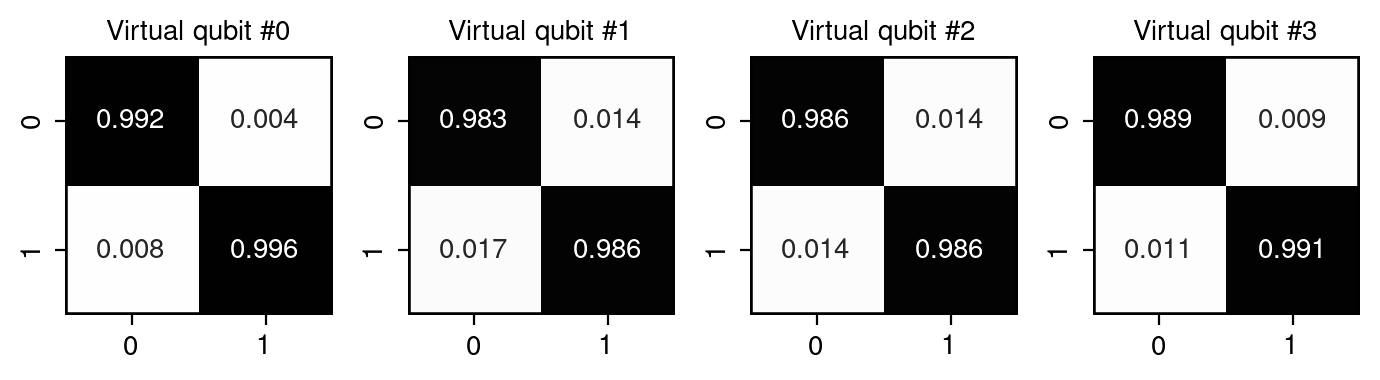

In [6]:
import matplotlib.pyplot as plt
from seaborn import heatmap

plt.rcParams.update({'text.usetex': True, 'font.family': 'Helvetica'})

fig, axes = plt.subplots(ncols=4, dpi=200, layout='tight', figsize=[7, 2])

for ax, (qubit, matrix) in zip(axes, m3_calibrations.items()):
    ax.set_title(f"Virtual qubit \\#{qubit}", fontsize=10)
    heatmap(
        matrix, vmin=0, vmax=1, cmap='binary', cbar=False, 
        annot=True, fmt='.3f', ax=ax,
    )
    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=2, color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=2, color='k',linewidth=2)

plt.show()

### Combine randomizations

As explained before, the process of error mitigation requiered the execution of _ensembles_ of randomized, yet equivalent, quantum circuits leading to a collection of results that we now need to reconcile. 

In practice, this can be done through a weighted sum of the resulting probability distributions according to the relative amount of shots assigned to each randomization. Given that we divided the number of shots evenly, such process simplifies to basic averaging:

In [7]:
from collections import defaultdict

def aggregate_counts(counts_iterable):
    """Aggregate counts."""
    aggregate = defaultdict(lambda: 0)
    for counts in counts_iterable:
        for readout, count in counts.items():
            aggregate[readout] += count
    return aggregate

results_dict = {
    noise_factor: aggregate_counts(counts_list) 
    for noise_factor, counts_list in results_dict.items()
}

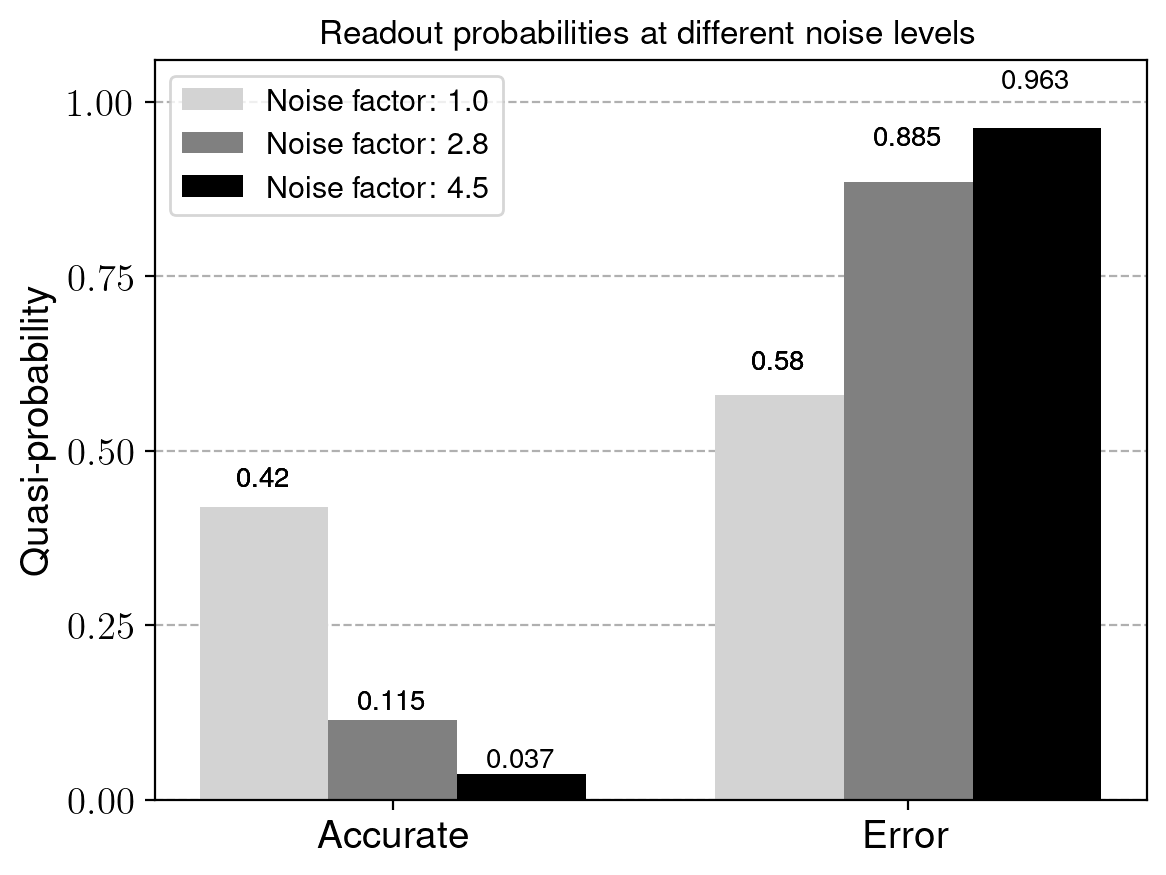

In [8]:
from qiskit.visualization import plot_distribution
from copy import deepcopy
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
fig, ax = plt.subplots(dpi=200)

ACCURATE_READOUT = "0" * NUM_QUBITS
plots_dict = deepcopy(results_dict)
plots_dict = {
    nf: {"0": counts.pop(ACCURATE_READOUT), "1": sum(counts.values())}
    for nf, counts in plots_dict.items()
}

plot_distribution(
    [plots_dict.get(nf) for nf in NOISE_FACTORS], 
    legend=[f"Noise factor: {nf:.1f}" for nf in NOISE_FACTORS],
    color=['lightgray', 'gray', 'black'],
    title="Readout probabilities at different noise levels",
    ax=ax,
)
ax.set_xticklabels(['Accurate', 'Error'], rotation=0)
ax.legend(fontsize=11)

plt.show()

### Evaluate expectation values

Now that we have the probability distributions associated to executions at different levels of noise, we can compute expecation values out of them.

For this we will look at two simple, yet representative, observables:

$$
\hat{O}_\text{singles} := \frac{1}{N}\sum_{q=0}^{N-1} Z_{q} \; , \quad
\hat{O}_\text{doubles} := \frac{1}{N}\sum_{q=0}^{N-1} Z_{q} Z_{q+1} \; ;
$$

capturing single qubit expecation values, and nearest-neighbor two-qubit correlations (i.e. w/ periodic boundary conditions) on average.

On top of them, we will also take a look at their average, which can be interpreted as a normalized _Ising model Hamiltonian_ (i.e. maximum energy equal to one):

$$
\hat{O}_\text{average} := 
\frac{1}{2N}\sum_{q=0}^{N-1} \left( Z_{q} + Z_{q} Z_{q+1} \right) \equiv
\hat{H}_\text{ising} \; .
$$

In [9]:
from qiskit.result import marginal_distribution, sampled_expectation_value

def compute_singles_expval(counts, num_qubits):
    """Compute average single Pauli-Z expectation value."""
    expval = 0
    for qubit in range(num_qubits):
        qubits = [qubit]
        marginal = marginal_distribution(counts, qubits)
        marginal = M3.apply_correction(marginal, qubits)
        expval += sampled_expectation_value(marginal, 'Z')
    return expval / num_qubits

def compute_doubles_expval(counts, num_qubits):
    """Compute average, nearest-neightbor, double Pauli-Z expectation value."""
    expval = 0
    for qubit in range(num_qubits):
        qubits = [qubit, (qubit + 1) % num_qubits]
        marginal = marginal_distribution(counts, qubits)
        marginal = M3.apply_correction(marginal, qubits)
        expval += sampled_expectation_value(marginal, 'ZZ')
    return expval / num_qubits

> **NOTICE:**
> 
> M3 readout corrections are applied here to all marginal distributions used for the computation of each individual expectation value in the sums.
  

In [10]:
singles_expvals = {
    noise_factor: compute_singles_expval(distribution, NUM_QUBITS) 
    for noise_factor, distribution in results_dict.items()
}

doubles_expvals = {
    noise_factor: compute_doubles_expval(distribution, NUM_QUBITS) 
    for noise_factor, distribution in results_dict.items()
}

average_expvals = {
    noise_factor: (singles_expvals.get(noise_factor) + doubles_expvals.get(noise_factor)) / 2
    for noise_factor in NOISE_FACTORS
}

> **WARNING:**
>  
>    For the sake of simplicity in the present Notebook we only focus on expectation values.
>    Nevertheless, a more complete statistical description will necessarily incorporate information about the resulting *standard error*. 
>    We leave this as an exercise for the interested reader.

We can now plot these results and see what we have before performing the last step in the mitigation process:

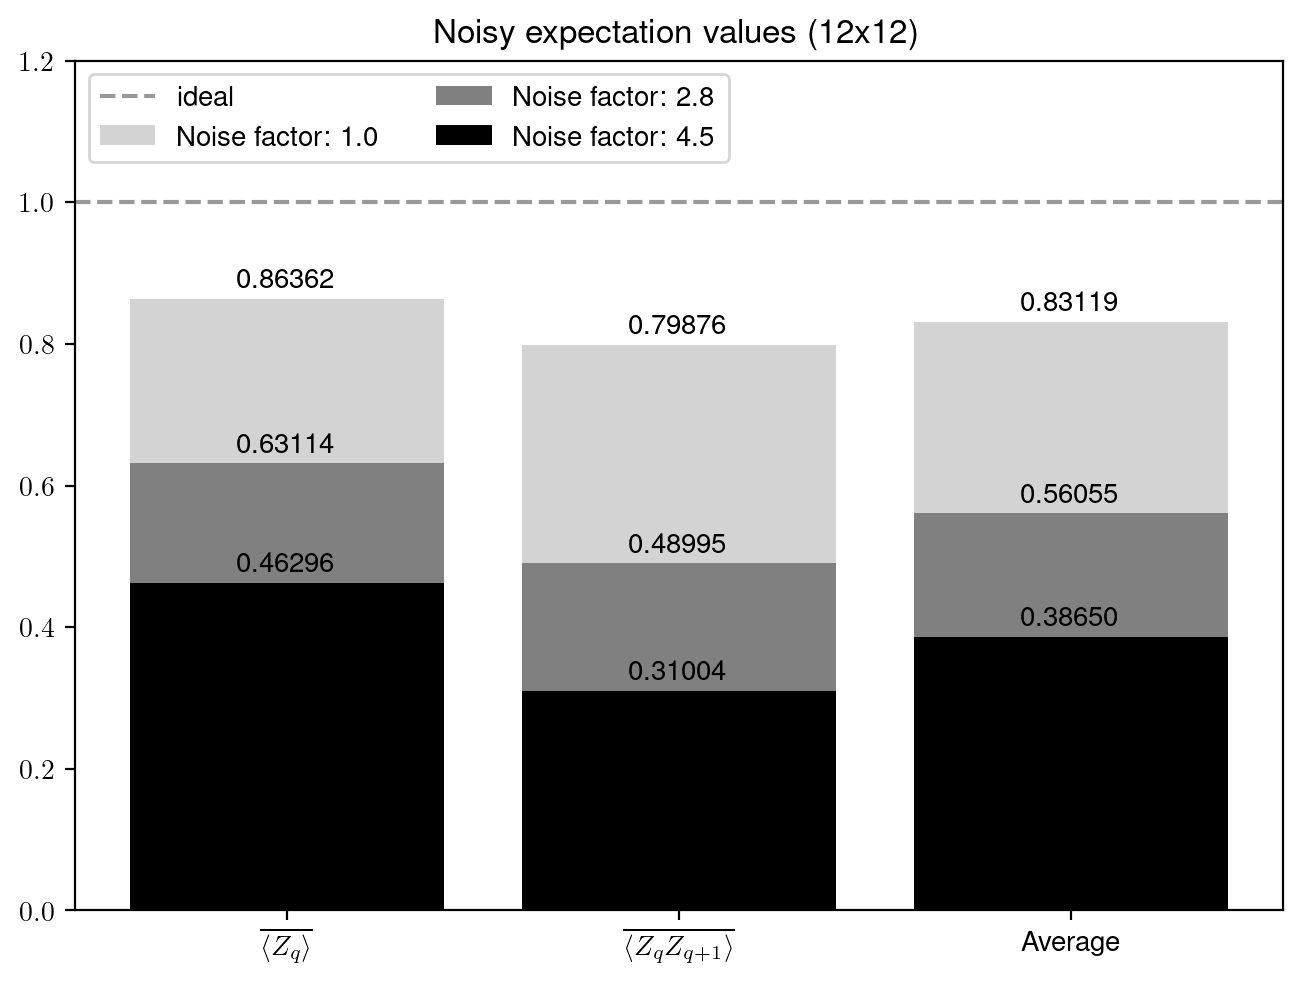

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

OBSERVABLES = (
    r'$\overline{\langle{Z_{q}}\rangle}$', 
    r'$\overline{\langle{Z_{q}Z_{q+1}}\rangle}$', 
    r'Average',
)
COLORS = dict(zip(NOISE_FACTORS, ['lightgray', 'gray', 'black']))

fig, ax = plt.subplots(dpi=200, layout='constrained')

for noise_factor in NOISE_FACTORS:
    expvals = (
        singles_expvals.get(noise_factor),
        doubles_expvals.get(noise_factor),
        average_expvals.get(noise_factor),
    )
    bars = ax.bar(
        OBSERVABLES, expvals, 
        label=f"Noise factor: {noise_factor:.1f}", 
        color=COLORS.get(noise_factor, 'skyblue')
    )
    ax.bar_label(bars, fmt='%.5f', padding=2)

ax.axhline(y=1.0, color='k', linestyle='--', label="ideal", alpha=0.4)
ax.set_ylim([0.0, 1.2])

ax.set_title(f"Noisy expectation values ({NUM_QUBITS}x{DEPTH})")
ax.legend(loc='upper left', ncols=2)

plt.show()

We see how the observable with larger Pauli-weight is more heavily affected by noise; and noise amplification via gate-folding works as expected.

### Extrapolate to zero-noise

The last step in the error mitigation process is to extrapolate to the zero noise limit for each of the observables at hand. We will use an out of the box linear extrapolation strategy without any advanced tuning or custom tailoring.

In [12]:
from zne.extrapolation import LinearExtrapolator

extrapolator = LinearExtrapolator()

singles_expvals[0.0] = extrapolator.extrapolate_zero(
    list(singles_expvals.keys()), list(singles_expvals.values())
).value

doubles_expvals[0.0] = extrapolator.extrapolate_zero(
    list(doubles_expvals.keys()), list(doubles_expvals.values())
).value

average_expvals[0.0] = (singles_expvals.get(0.0) + doubles_expvals.get(0.0)) / 2

Furthermore, if any of the extrapolated values exceeds the _maximum_/_minimum_ expectation value for our observable (i.e. $\pm1$ in these cases), we could truncate it in post processing. We leave this aside for the sake of clarity, and visualize the final extrapolation results. 

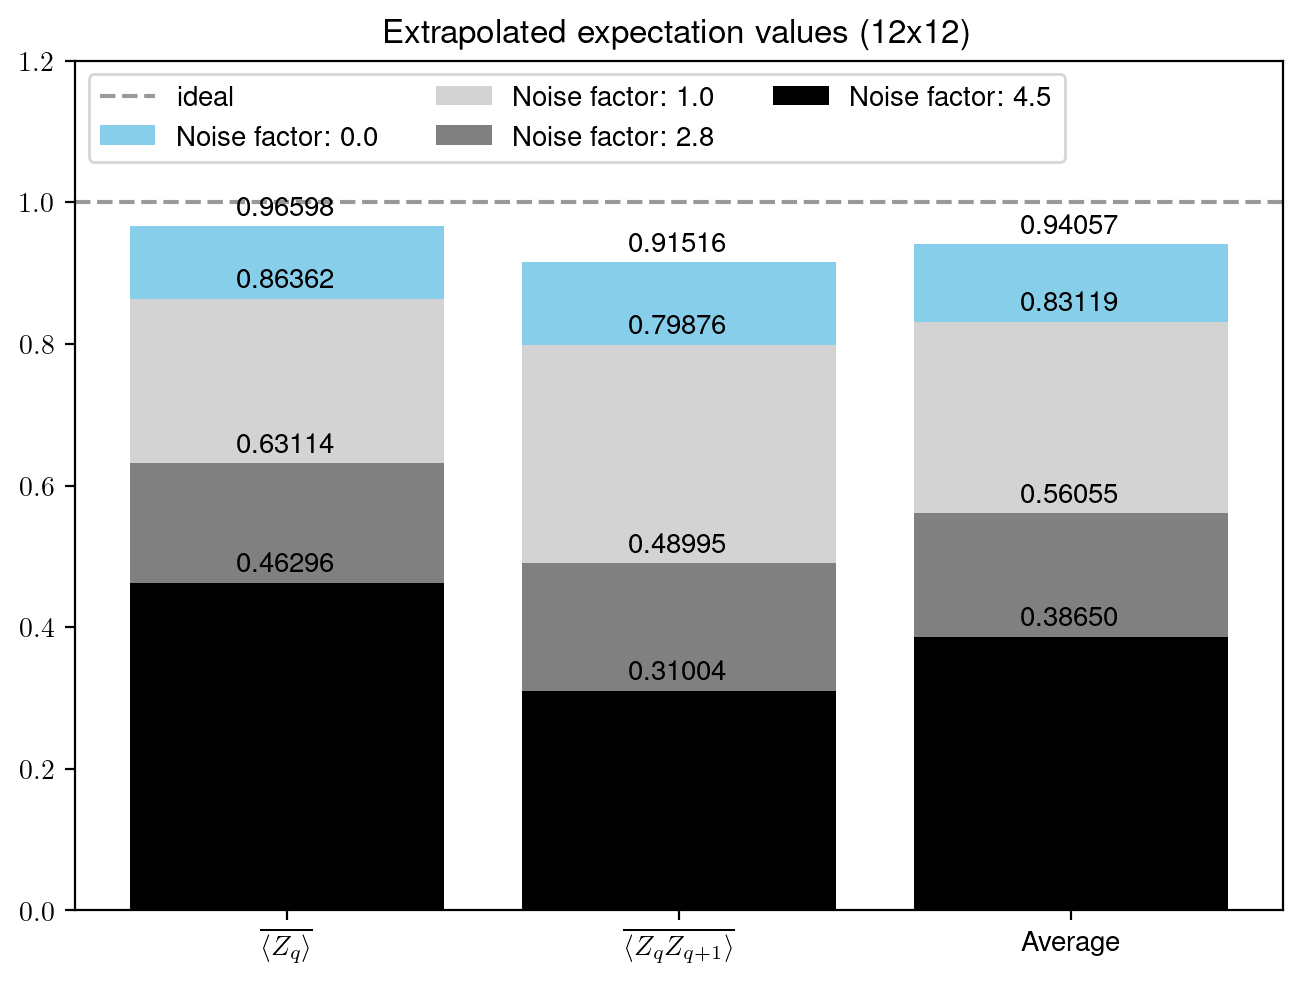

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

fig, ax = plt.subplots(dpi=200, layout='constrained')

for noise_factor in [0.0] + NOISE_FACTORS:
    expvals = (
        singles_expvals.get(noise_factor),
        doubles_expvals.get(noise_factor),
        average_expvals.get(noise_factor),
    )
    bars = ax.bar(
        OBSERVABLES, expvals, 
        label=f"Noise factor: {noise_factor:.1f}", 
        color=COLORS.get(noise_factor, 'skyblue')
    )
    ax.bar_label(bars, fmt='%.5f', padding=2)

ax.axhline(y=1.0, color='k', linestyle='--', label="ideal", alpha=0.4)
ax.set_ylim([0.0, 1.2])

ax.set_title(f"Extrapolated expectation values ({NUM_QUBITS}x{DEPTH})")
ax.legend(loc='upper left', ncols=3)

plt.show()

# Results across scales

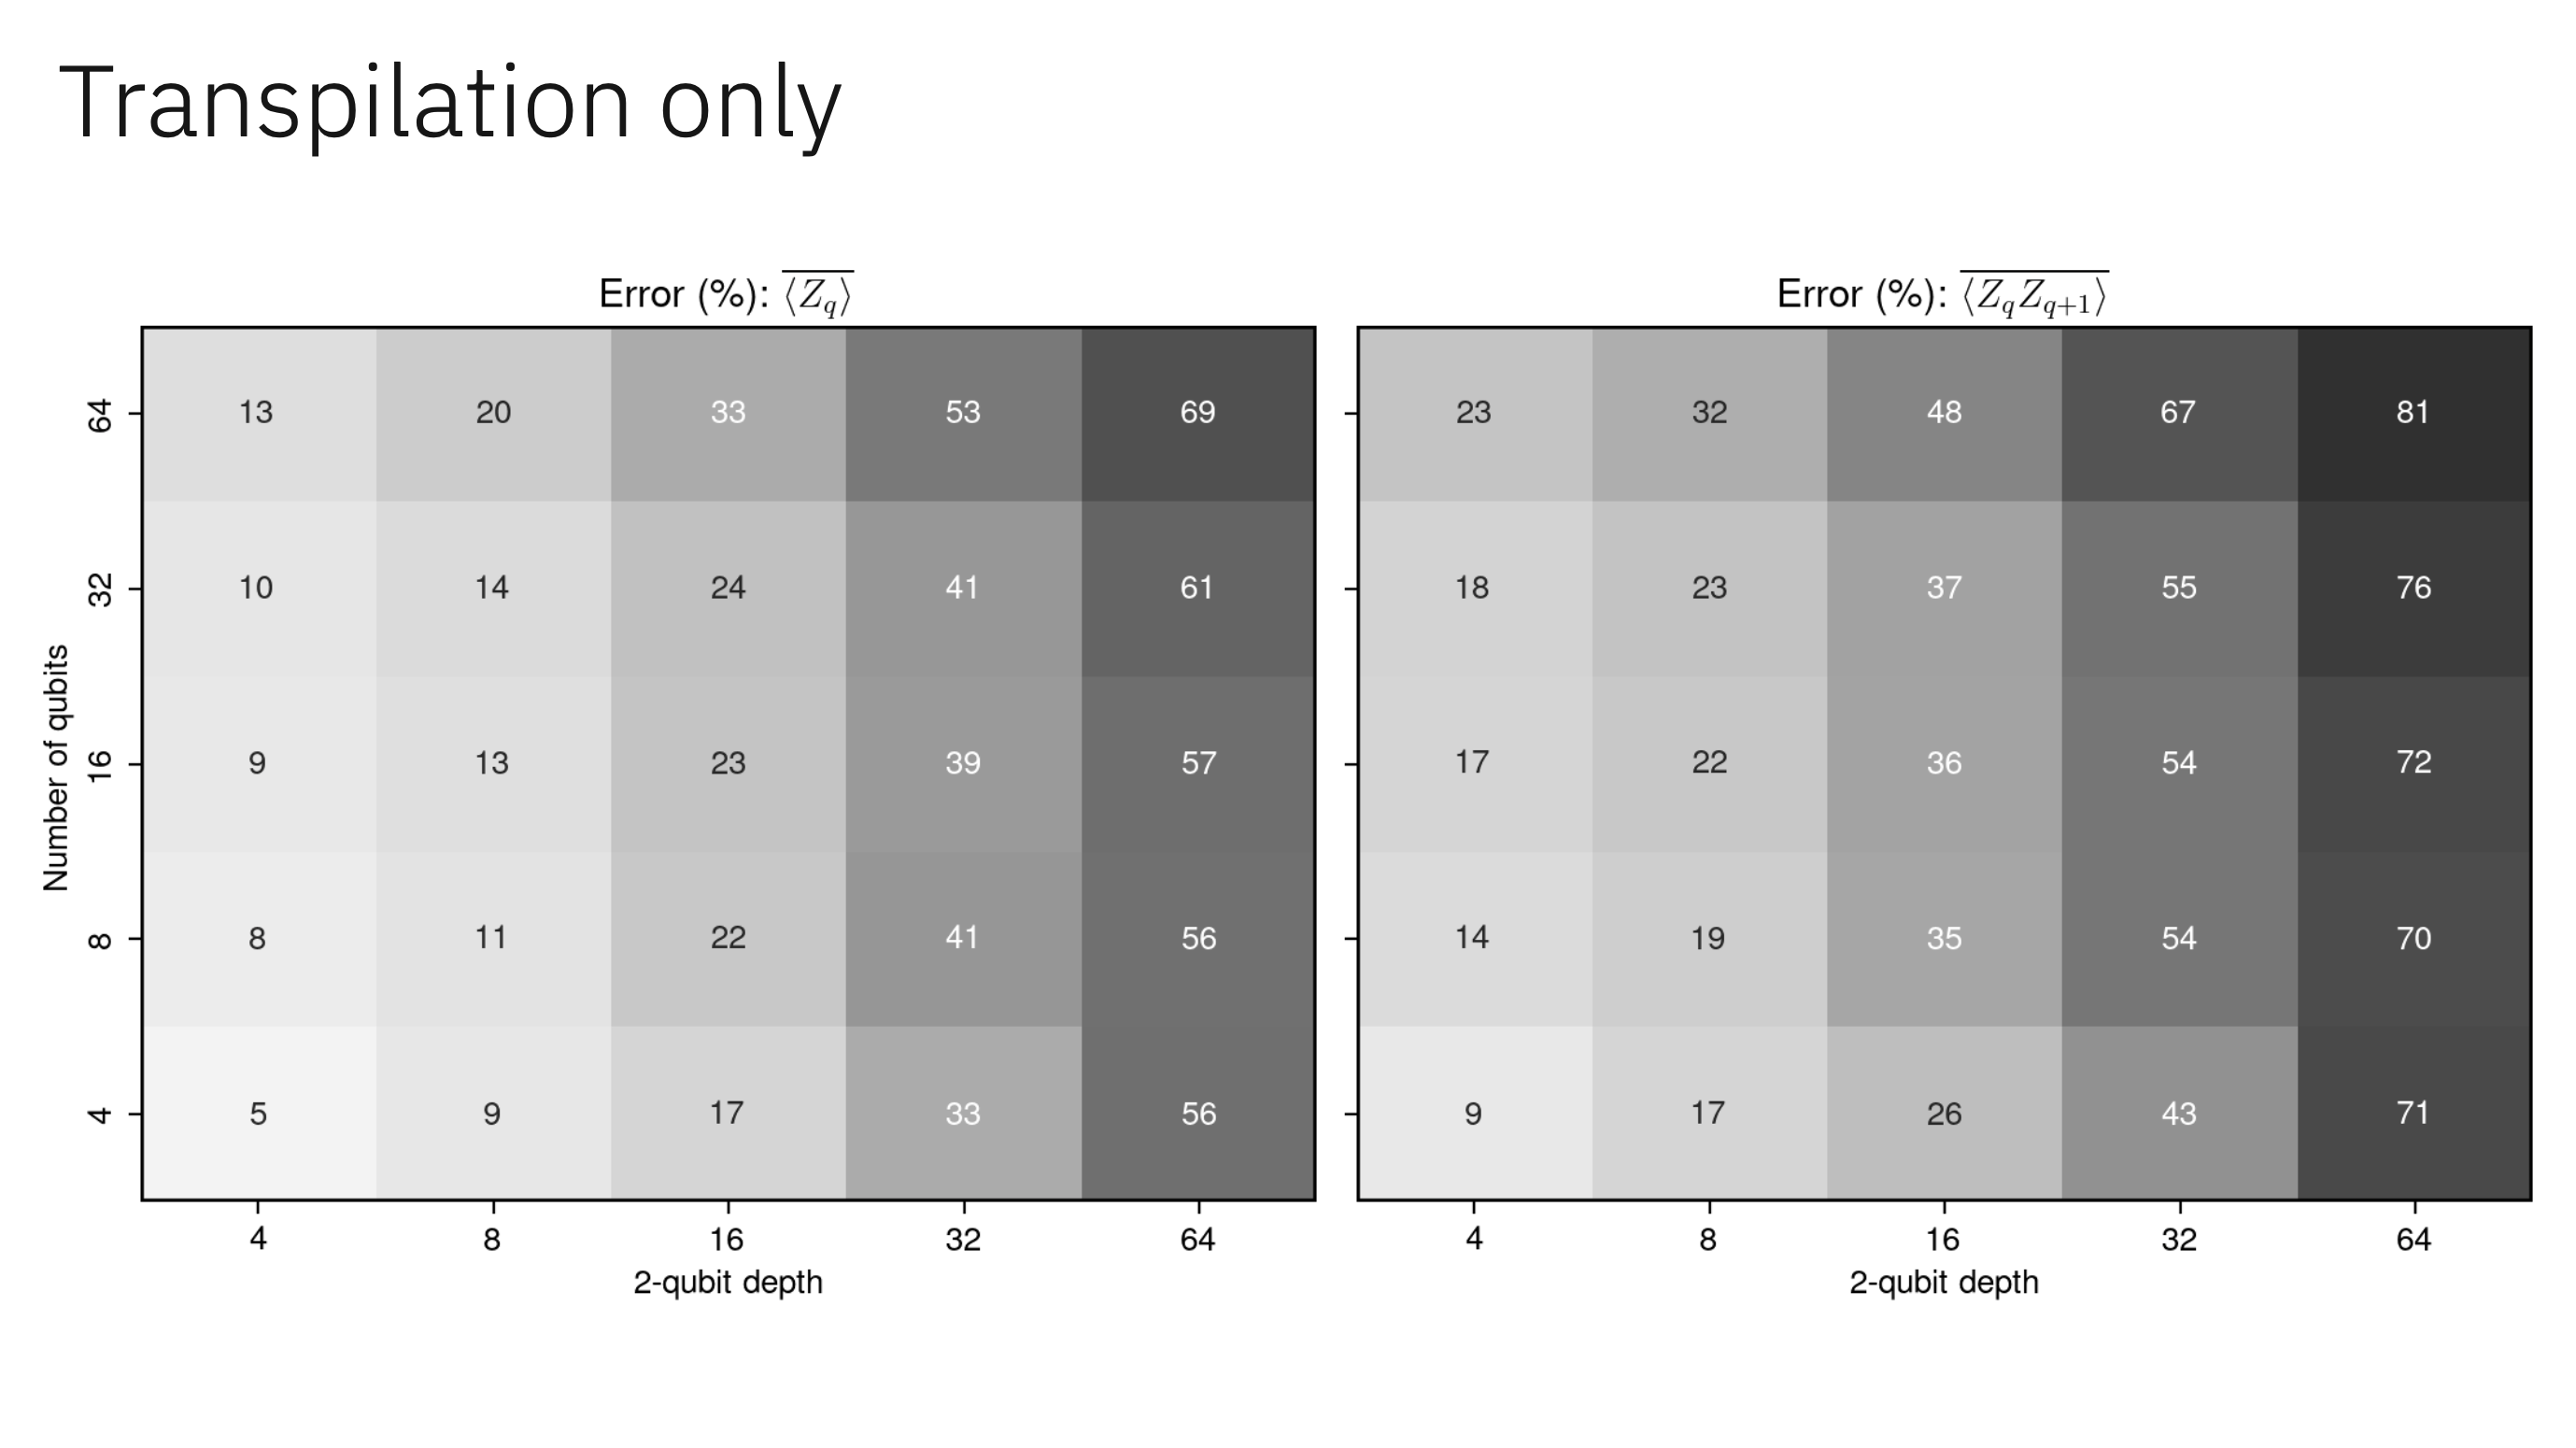
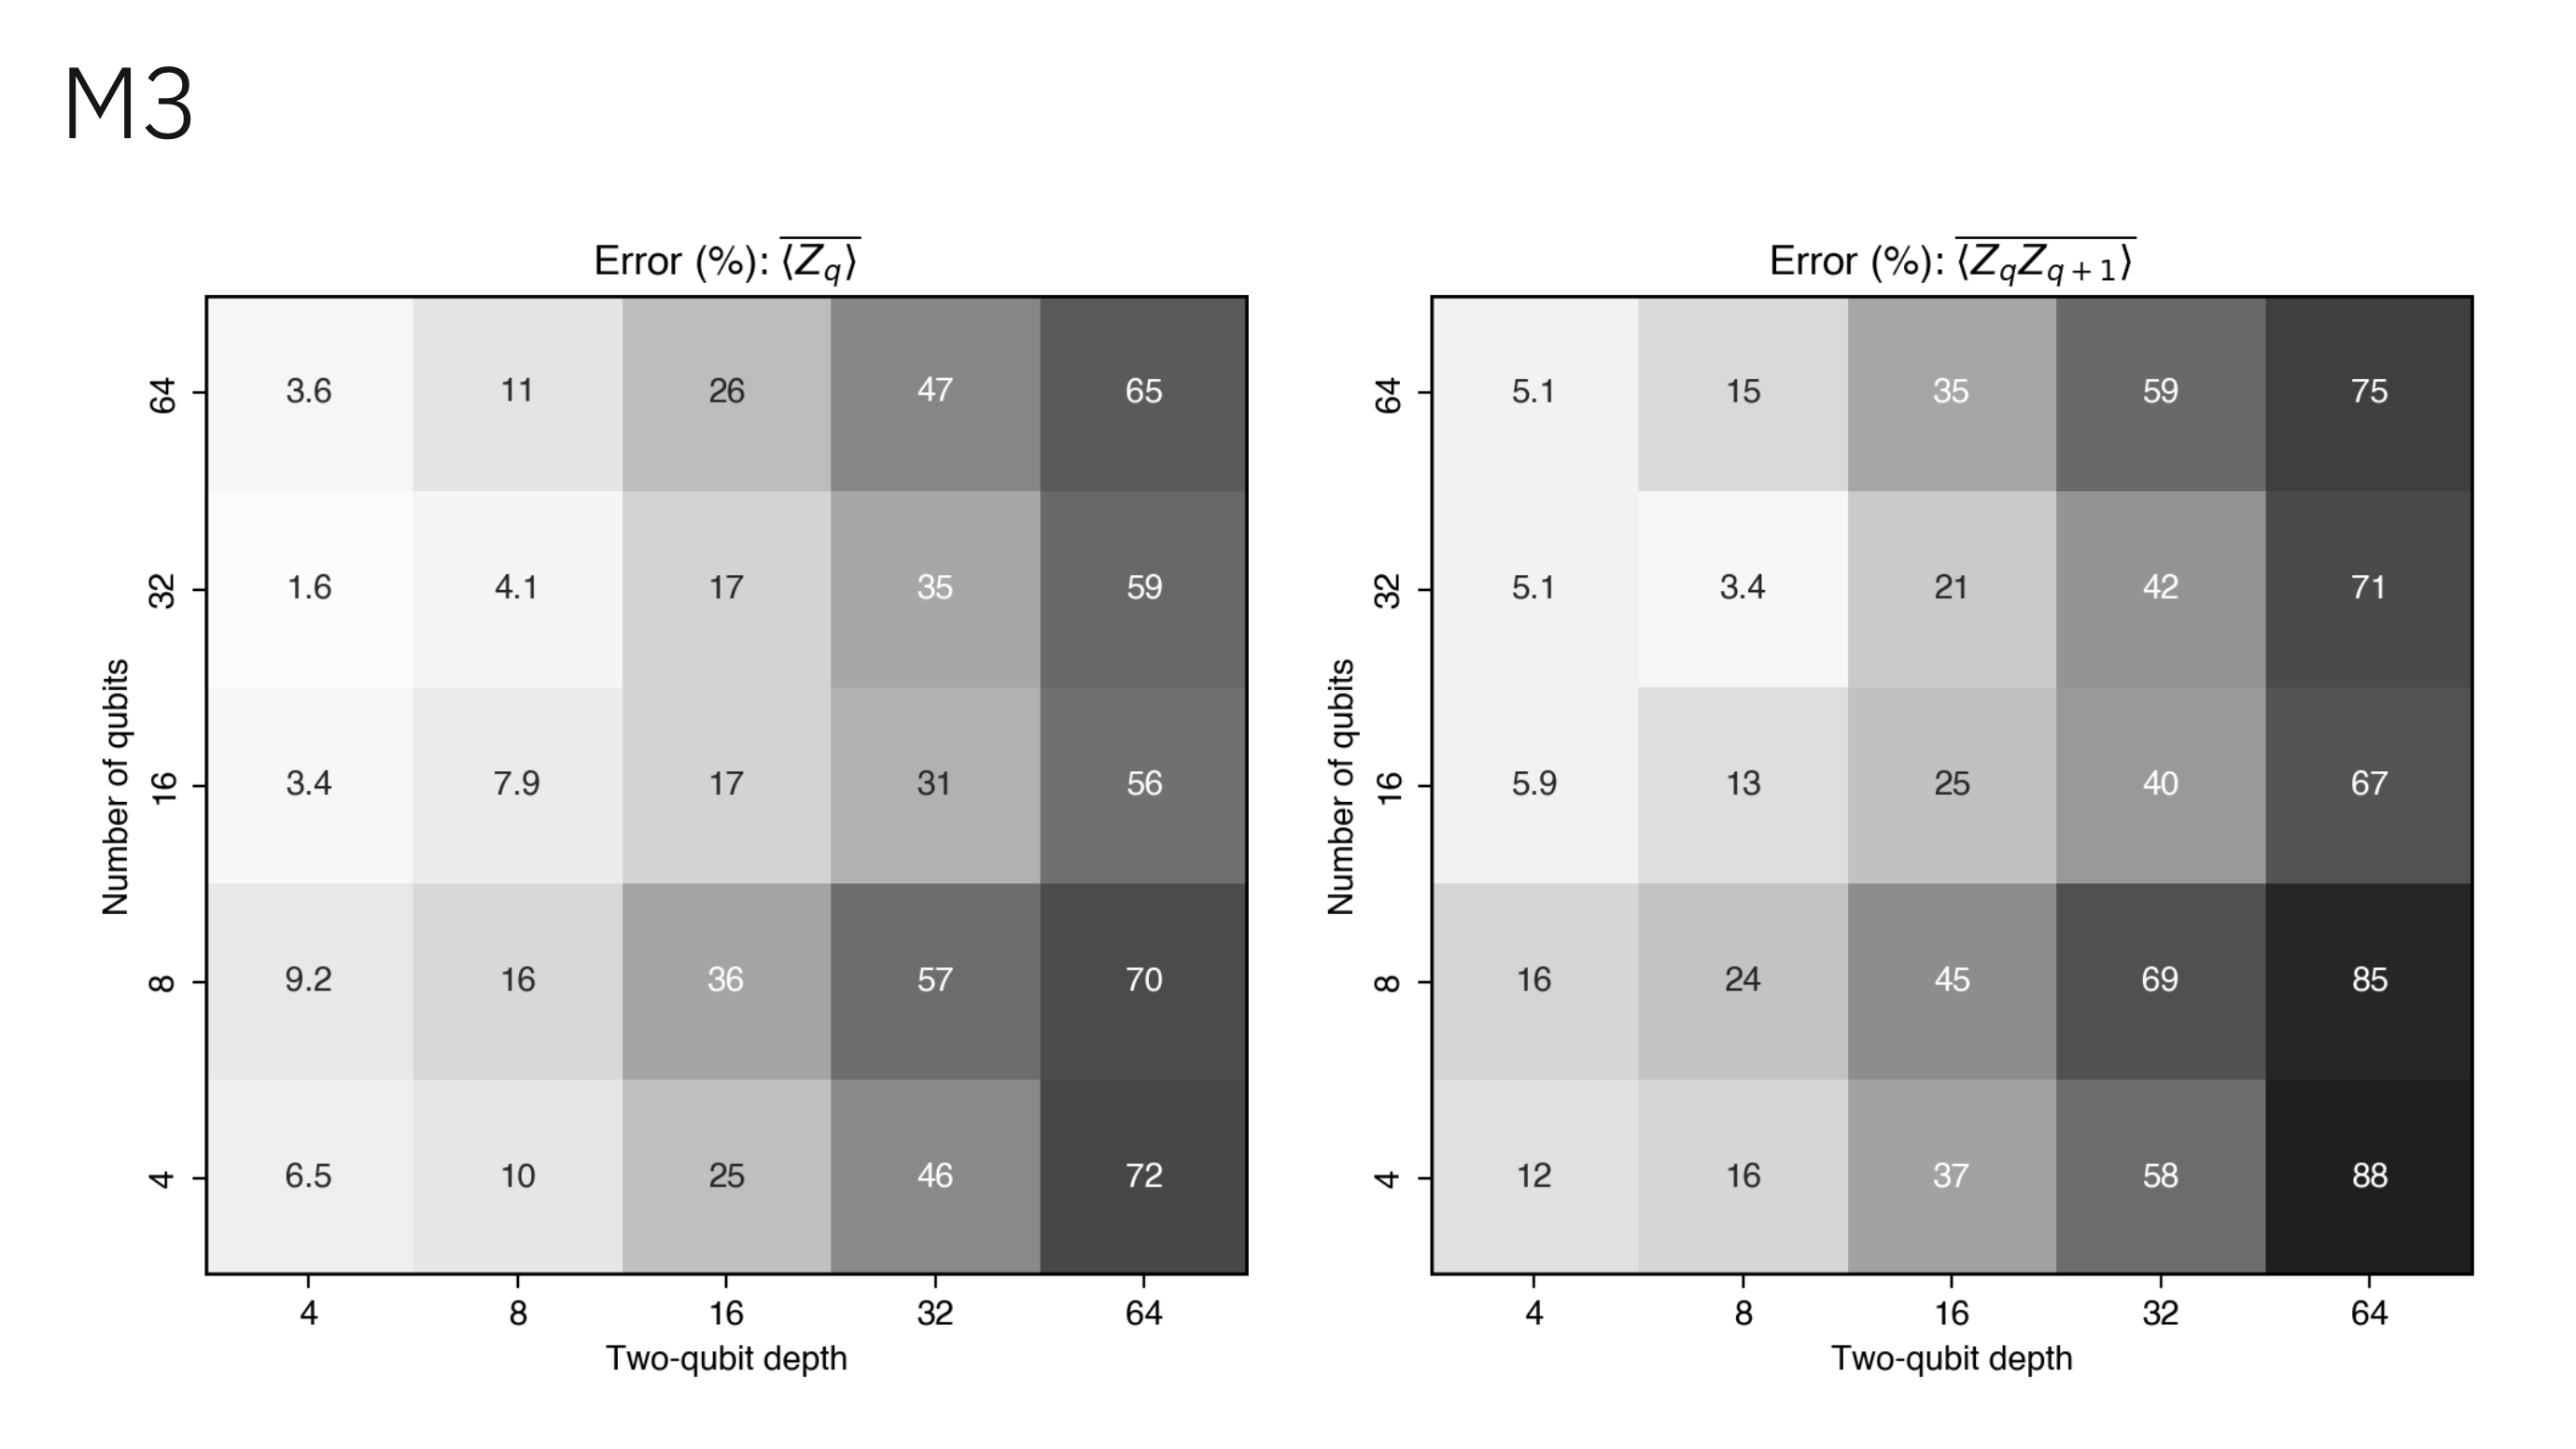
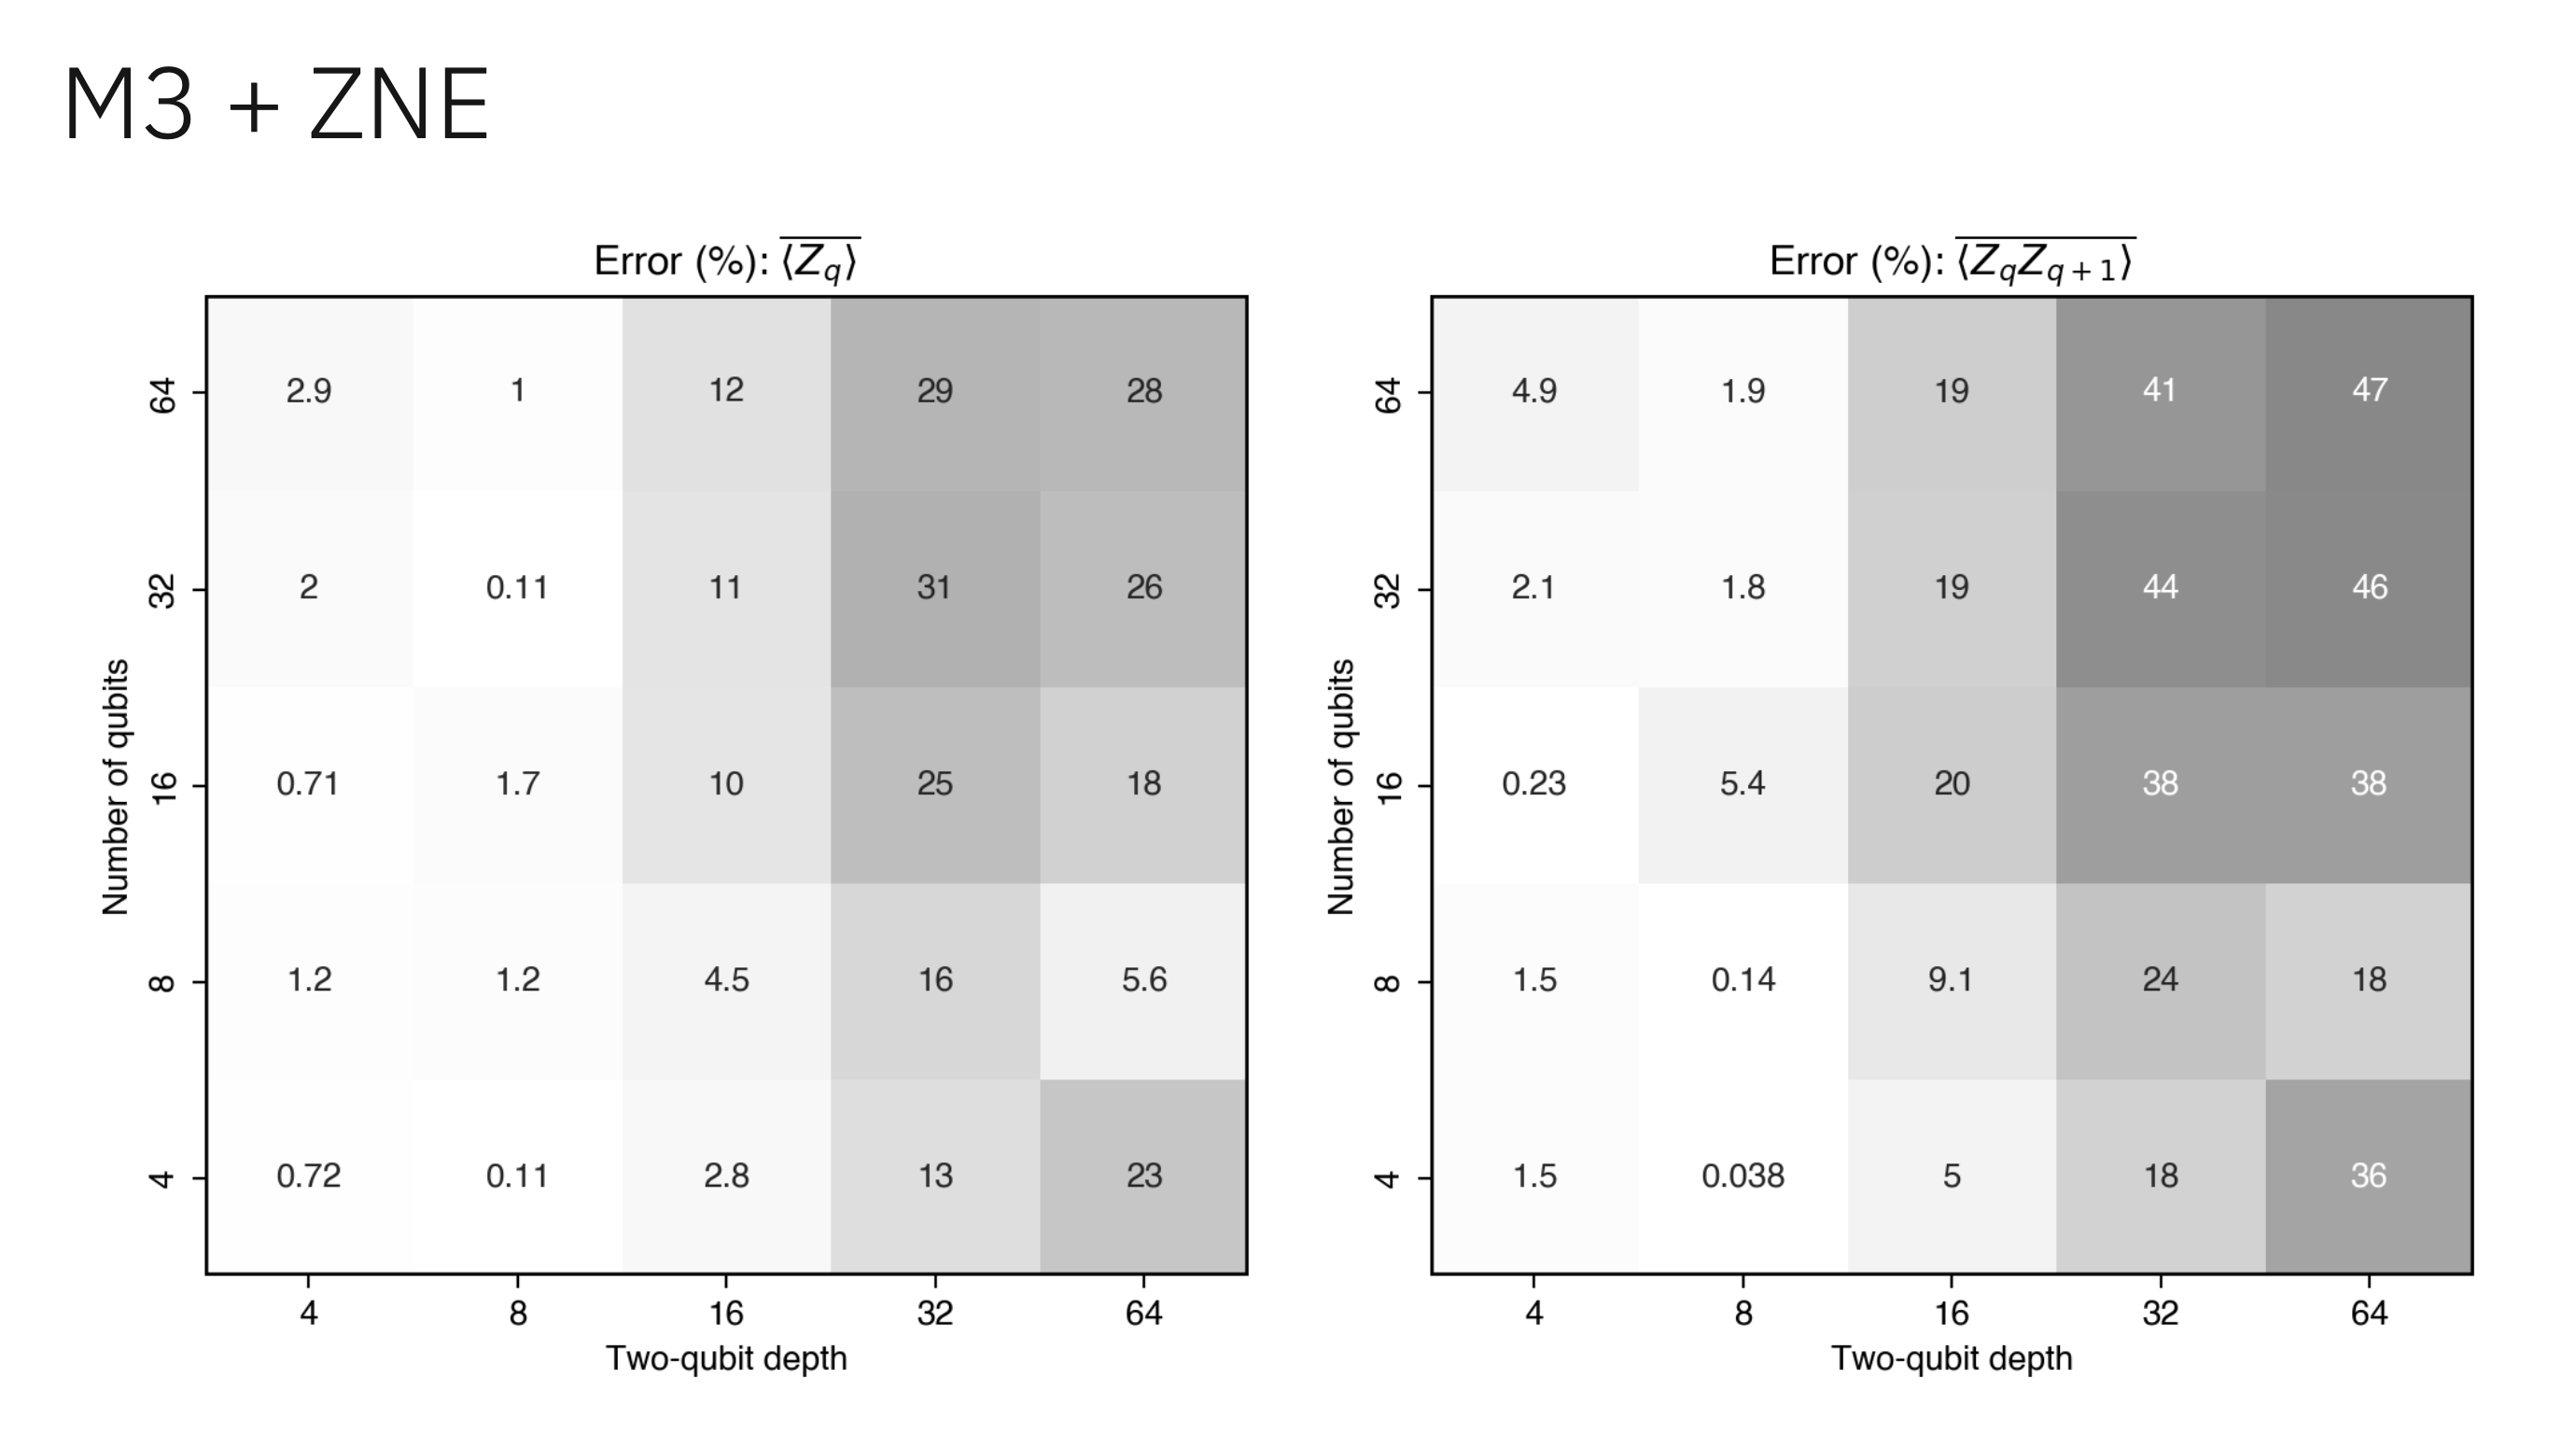
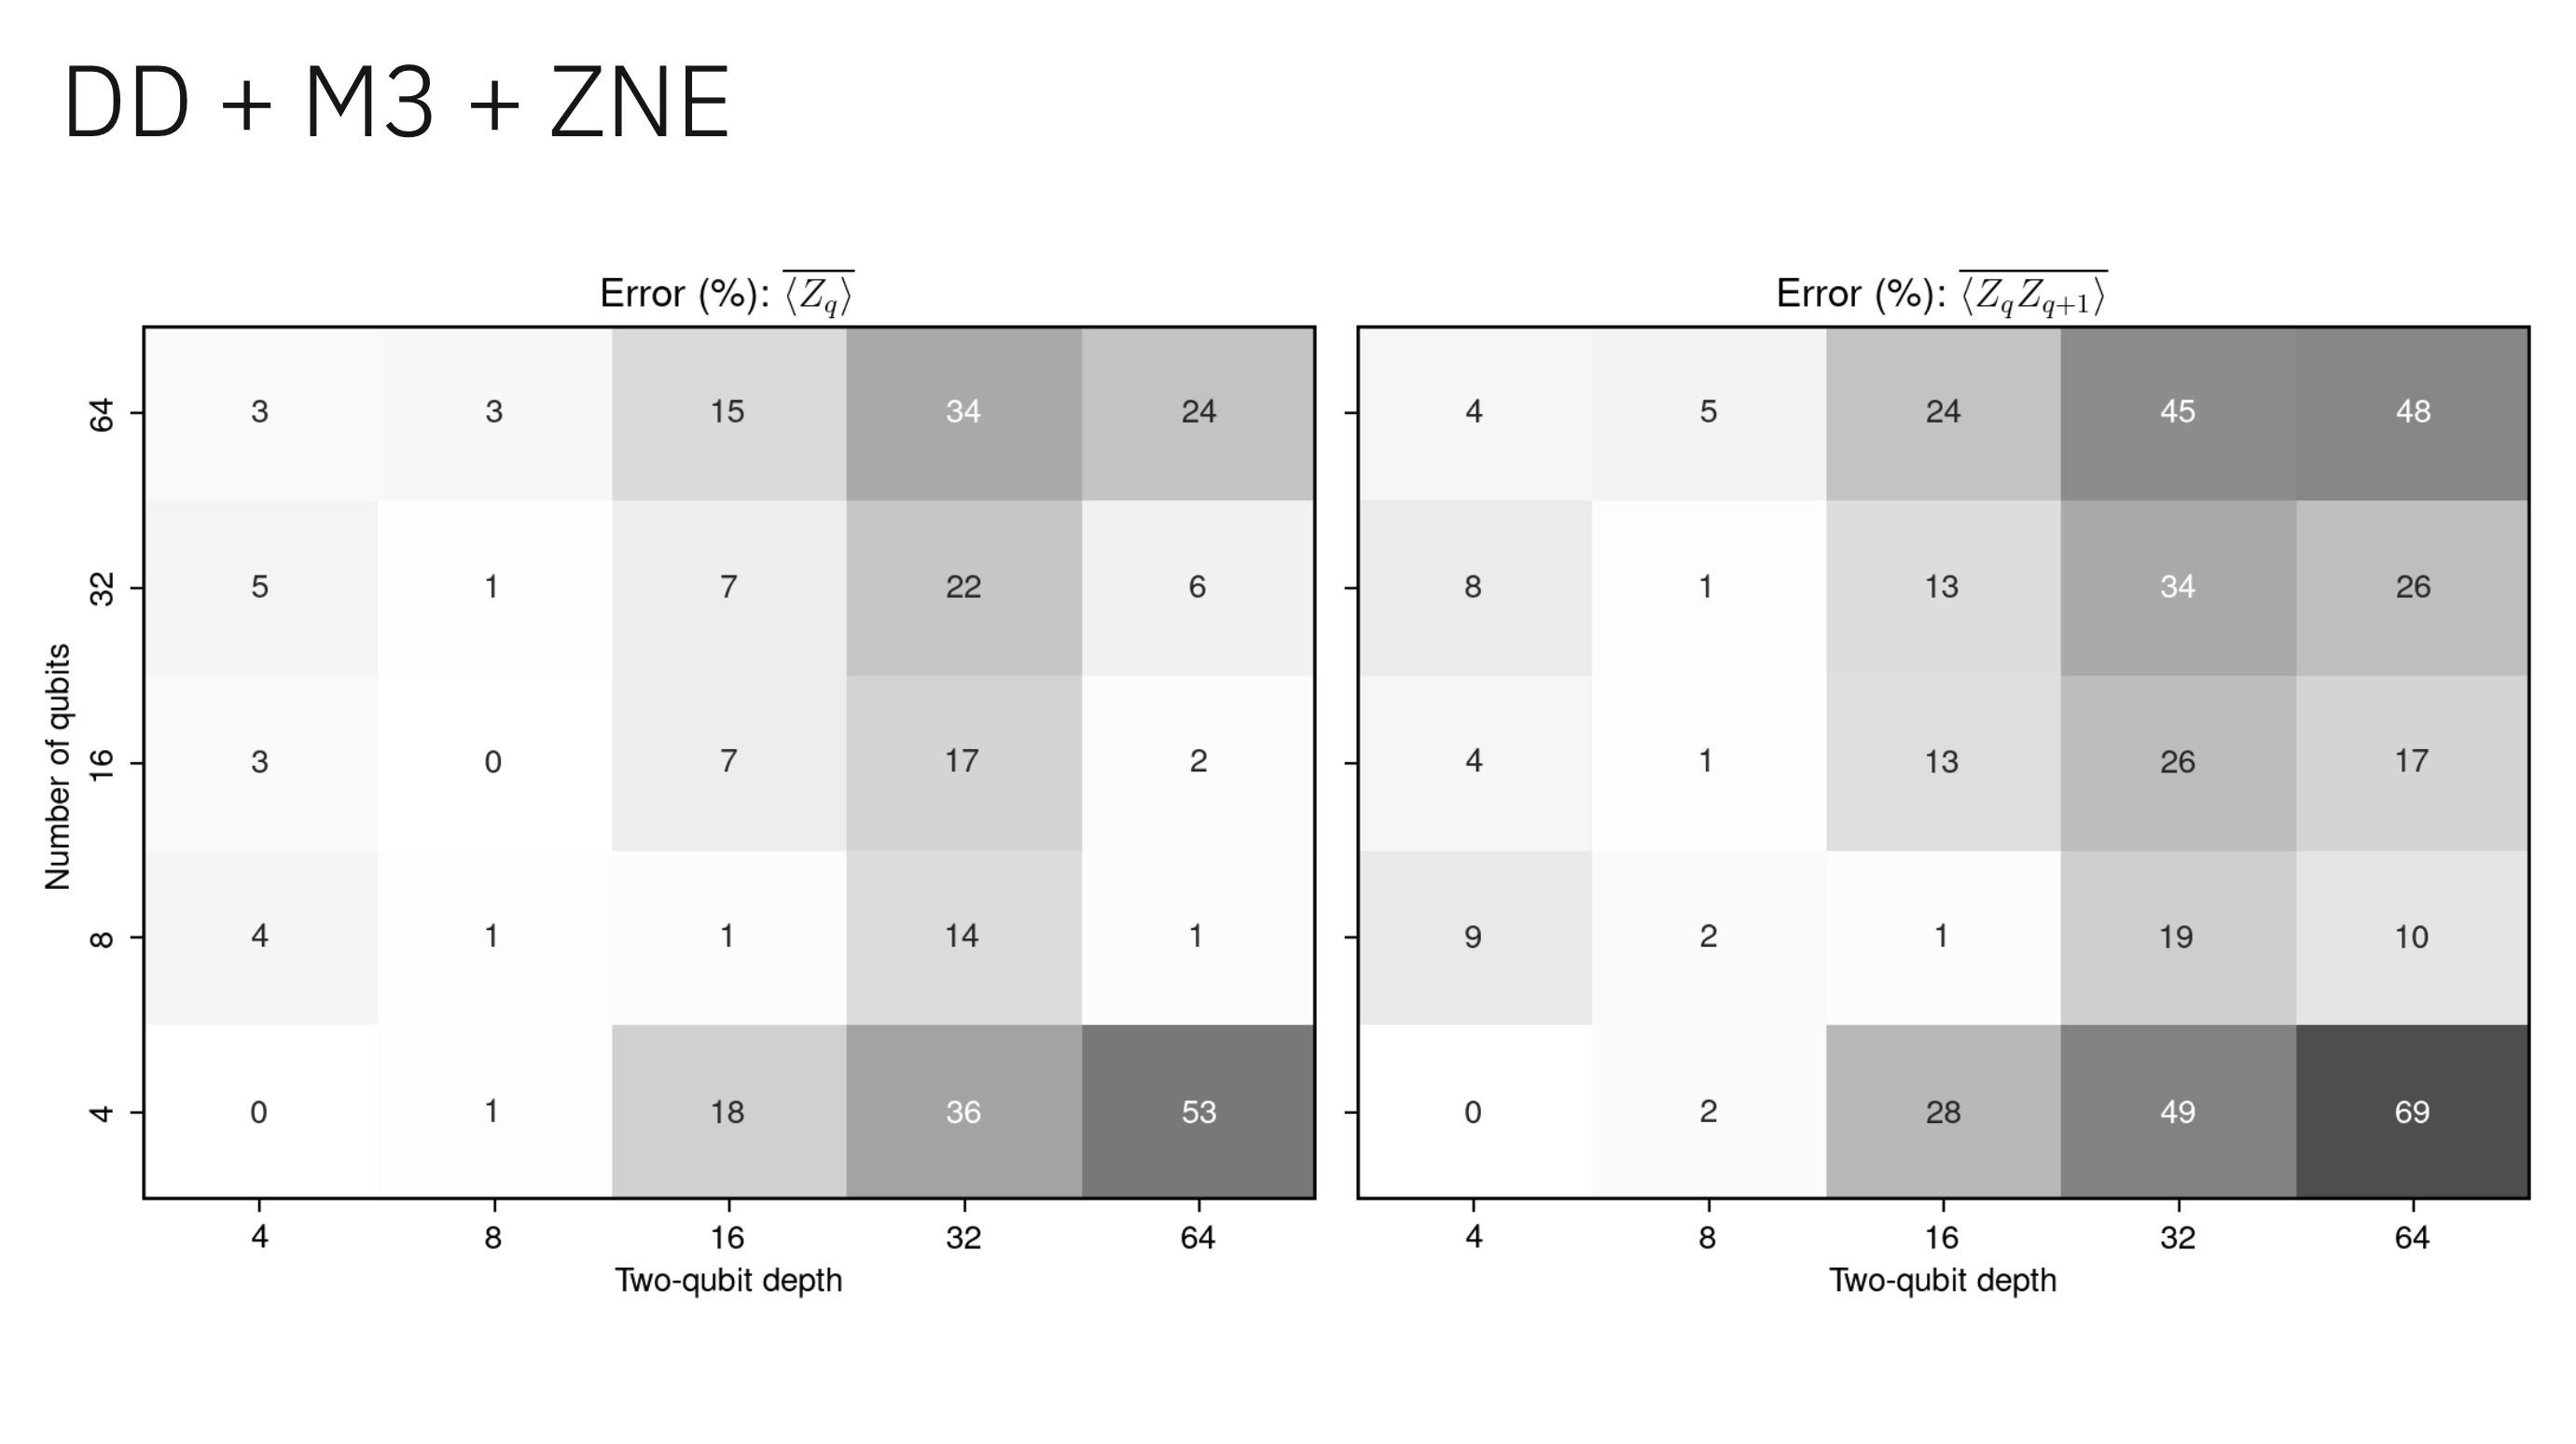
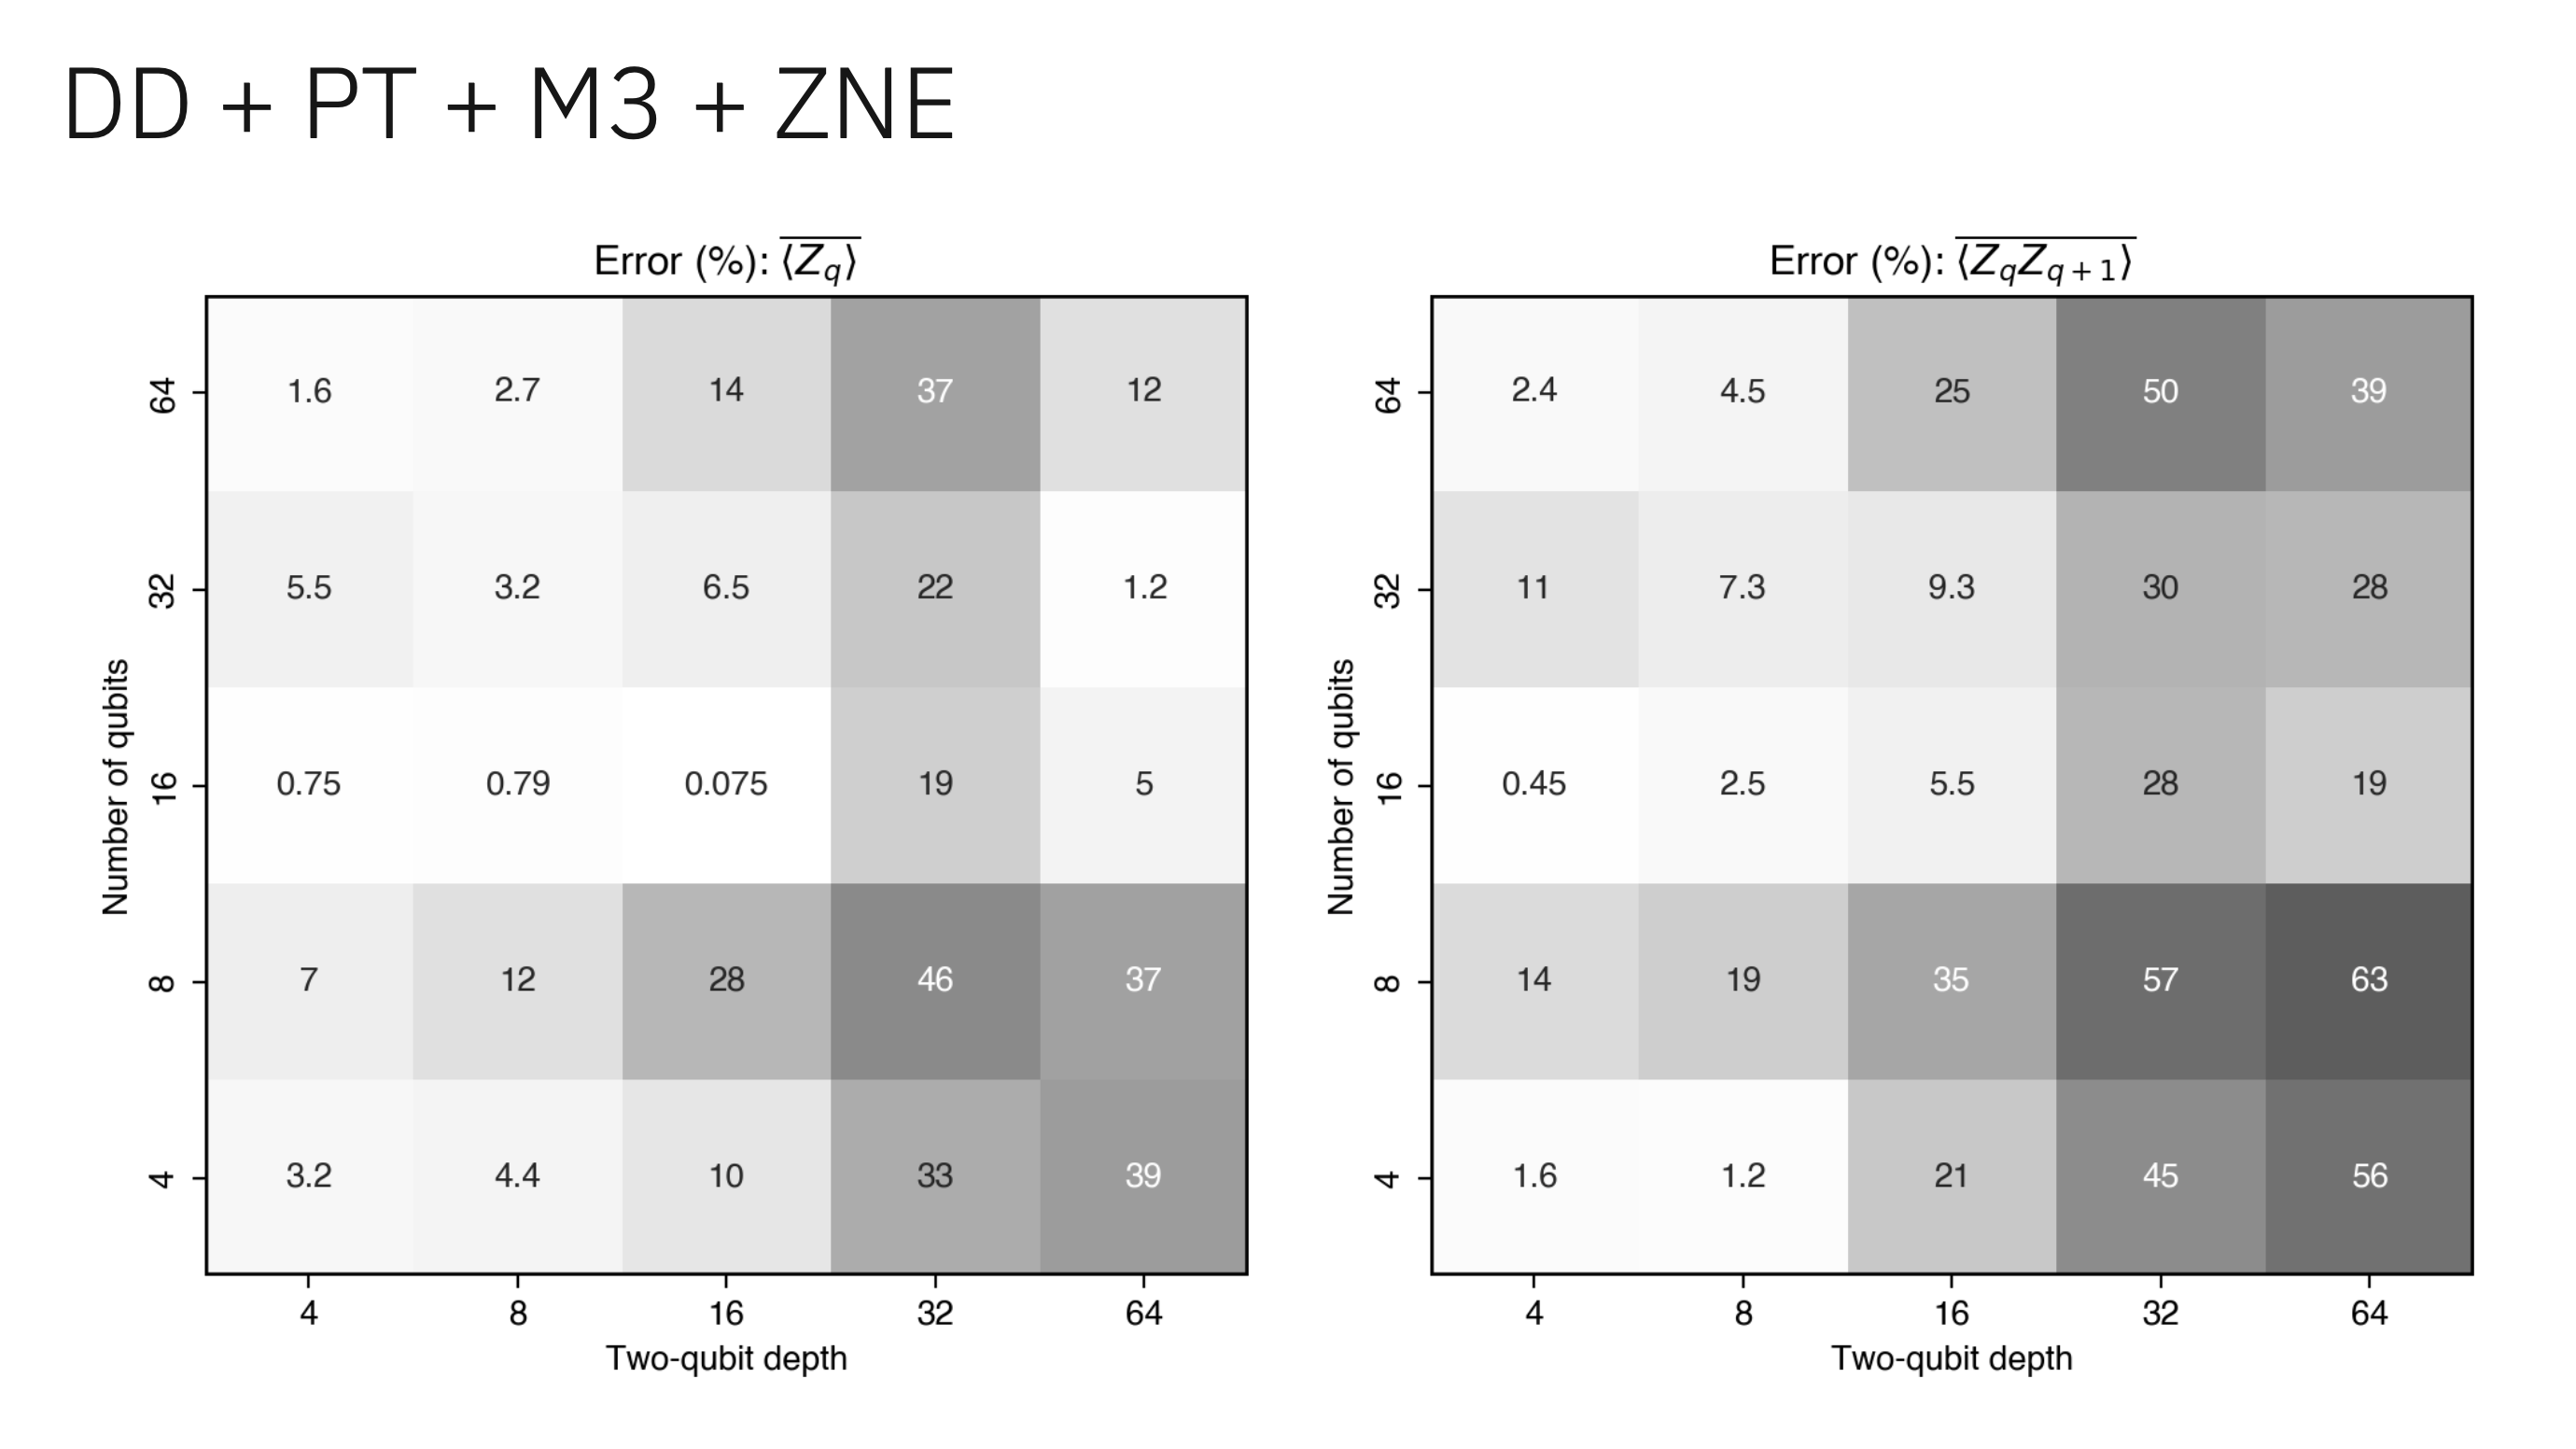

# Annex

## Acknowledgements

- **Derek Wang**: for scientific insight and guidance on MBL research.

## References

1. Majumdar et al, _Best practices for quantum error mitigation with digital zero-noise extrapolation_, [IEEE Xplore](https://ieeexplore.ieee.org/document/10313813)
2. Kim et al., _Evidence for the utility of quantum computing before fault tolerance_, [Nature 618, 500–505 (2023)](https://doi.org/10.1038/s41586-023-06096-3)
3. Shtanko et al., _Uncovering Local Integrability in Quantum Many-Body Dynamics_, [ArXiV:2307.07552](https://arxiv.org/abs/2307.07552)
4. Fahri et al., _A Quantum Approximate Optimization Algorithm_, [ArXiV:1411.4028](https://arxiv.org/abs/1411.4028)
5. Temme et al., _Error mitigation for short-depth quantum circuits_, [Phys. Rev. Lett. 119, 180509](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)
6. Nation et al., _Scalable mitigation of measurement errors on quantum computers_, [PRX Quantum 2, 040326](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040326)
7. Ezzell et al., _Dynamical decoupling for superconducting qubits: a performance survey_, [ArXiV:2207.03670](https://arxiv.org/abs/2207.03670)
8. Lidar, _Review of Decoherence Free Subspaces, Noiseless Subsystems, and Dynamical Decoupling_, [ArXiV:1208.5791](https://arxiv.org/abs/1208.5791)
9. Wallman et al., _Noise tailoring for scalable quantum computation via randomized compiling_, [Phys. Rev. A 94, 052325](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.94.052325)
10. Minev, _A tutorial on tailoring quantum noise - Twirling 101_, [Online](https://www.zlatko-minev.com/blog/twirling)
11. Di Matteo, _A short introduction to unitary 2-designs_, [Online](https://glassnotes.github.io/OliviaDiMatteo-Unitary2Designs.pdf)
12. _Qiskit: An Open-source Framework for Quantum Computing_, [PyPI](https://pypi.org/project/qiskit/)
13. Rivero et al., _Zero-noise extrapolation prototype_, [PyPI](https://pypi.org/project/prototype-zne/)
14. _Matrix-free Measurement Mitigation_, [PyPI](https://pypi.org/project/mthree/)

## Appendices

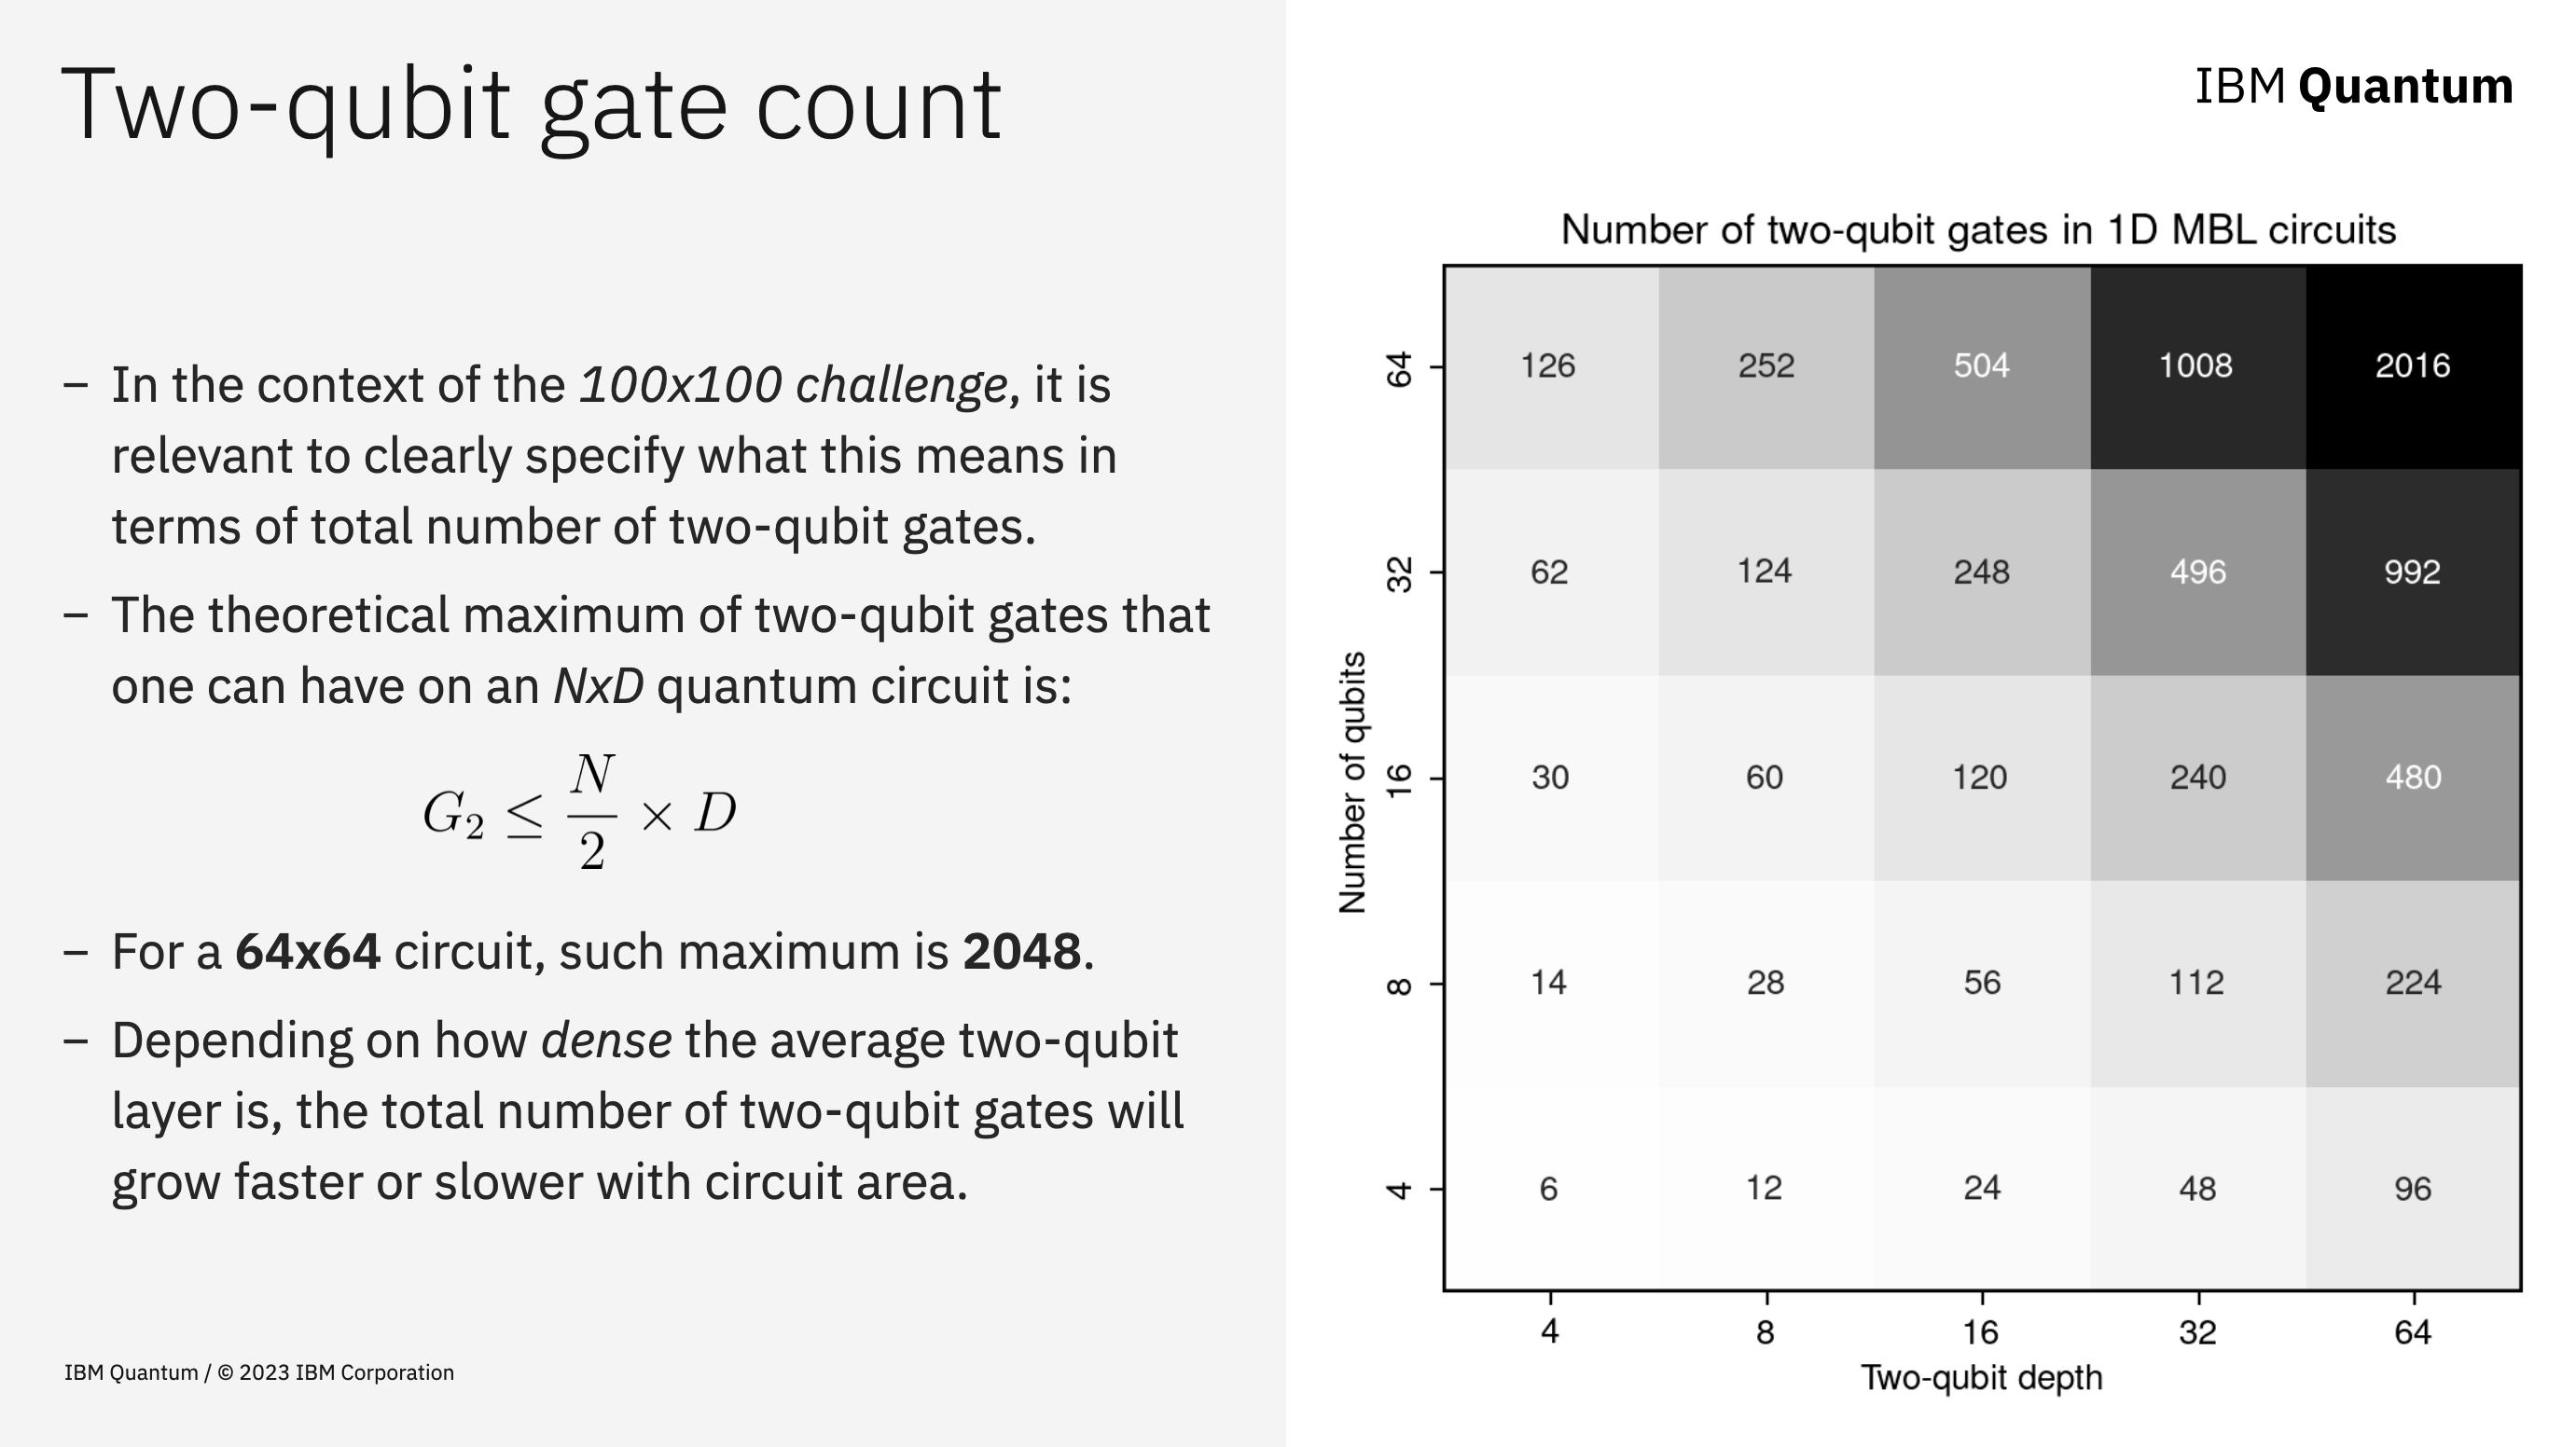
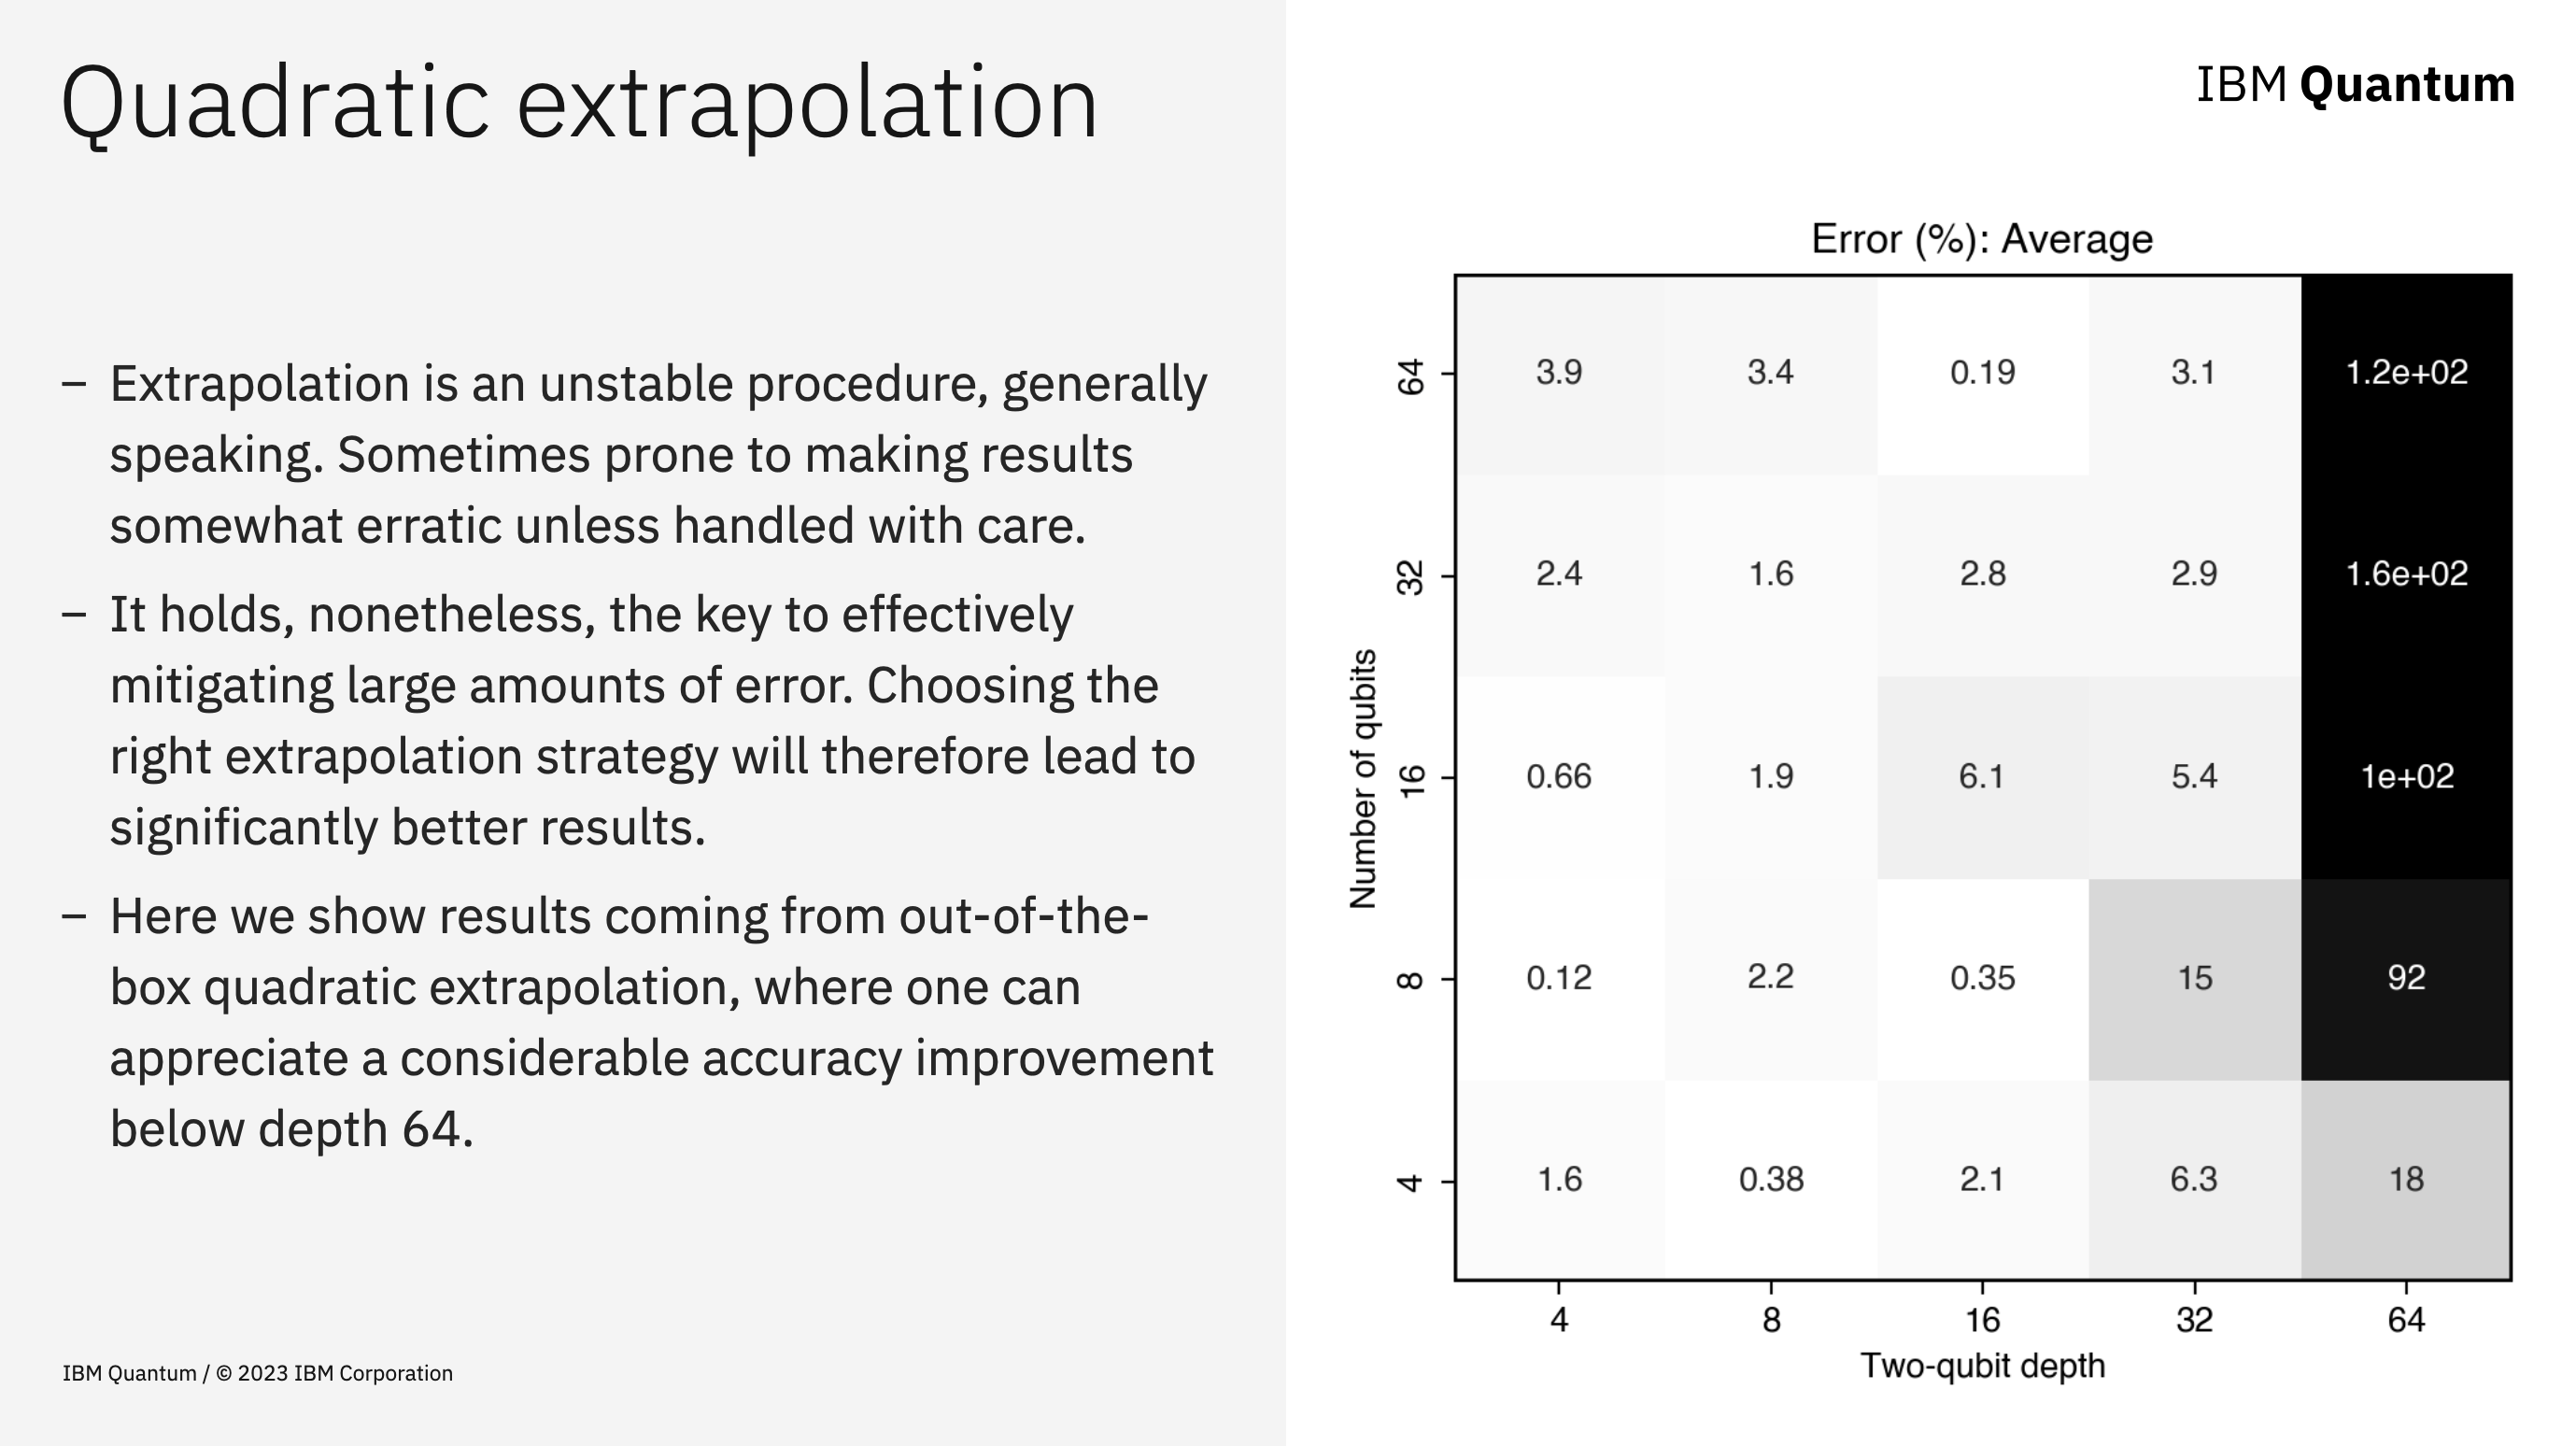
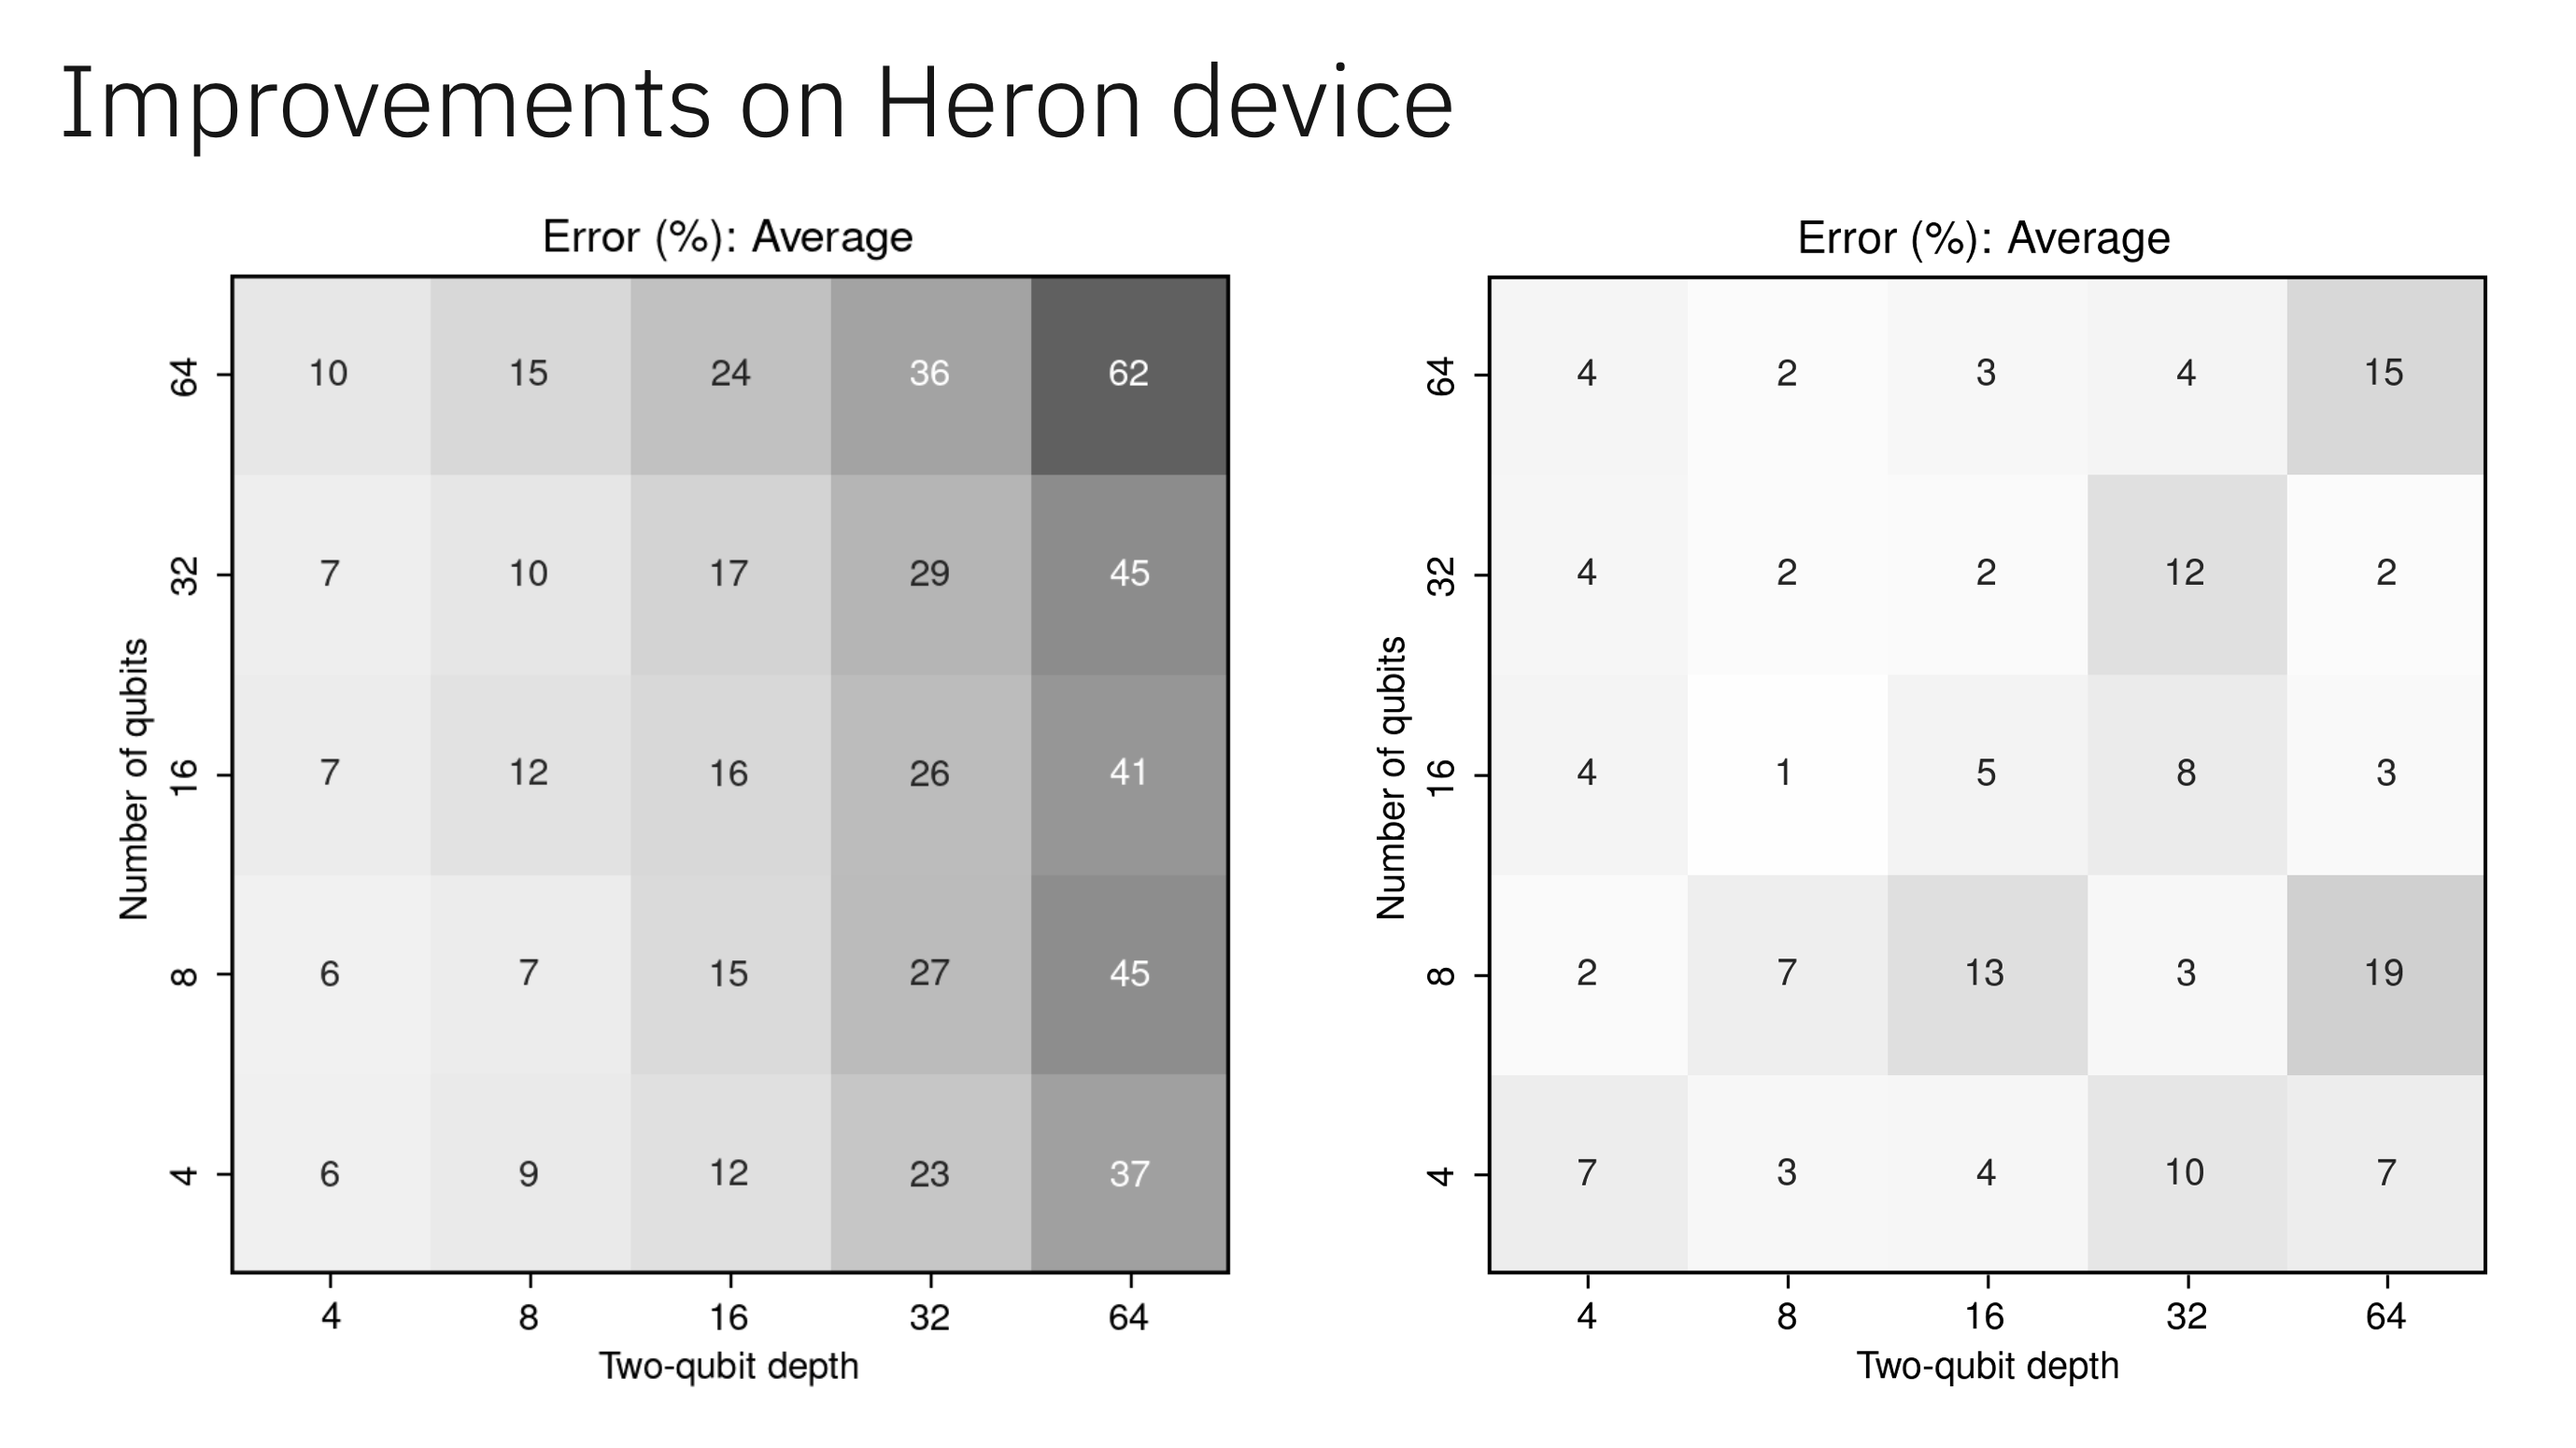

## Software dependencies

```
quantum-enablement @ git+https://github.com/IBM-Quantum-Technical-Enablement/quantum-enablement
qiskit[visualization] >= 1.0.0
qiskit-ibm-runtime >= 0.19.1
prototype-zne >= 1.3.1
mthree >= 2.6.3
```

---